<a href="https://colab.research.google.com/github/saritmaitra/Natural-Gas_Paul/blob/master/Sarit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data mining approach**
## **Data ingestion, processing, feature engineering and machine learning**

# **Code with ngrok**

In [0]:
# Installation of ngrok
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
# do it for only one time


### Install Dash
!pip install dash==1.4.1 
!pip install dash-html-components==0.13.2
!pip install dash-core-components==0.39.0
!pip install dash-table==3.1.7 
!pip install dash-daq==0.2.1
!pip install pyforest
!pip install quandl
!pip install mpl_finance
!pip install python_wtd
!pip install fredapi
!pip install EIA_python
!pip install python_wtd
!pip install termcolor

In [2]:
# Generate .py file to run with flask
%%writefile Sarit_app.py
from pyforest import *
import datetime, pickle, copy
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import quandl

from python_wtd import WTD
plt.style.use('ggplot')
from statistics import variance 
from random import randint
import scipy as sp
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, roc_auc_score
from xgboost import XGBClassifier

from fredapi import Fred

import eia

from python_wtd import WTD

from termcolor import colored
from sklearn.model_selection import cross_val_score, KFold, cross_validate, train_test_split, TimeSeriesSplit
from xgboost import XGBRegressor
import xgboost as xgb

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import dash_table


print('\033[4mNatural Gas continuous contract 1\033[0m')
NG = quandl.get("CHRIS/CME_NG1", authtoken="LSQpgUzwJRoF667ZpzyL") # natural gas continuous contract 1
NG = NG.loc['2000-01-01':,['Open', 'High', 'Low', 'Last', 'Volume']]
#print(NG)


# Cushing, OK WTI Spot Price FOB, Daily
print('\033[4mWTI Spot Price FOB, Daily (Dollars per Barrel)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    wti = pd.DataFrame(series_search)
    return wti

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='PET.RWTC.D'
      wti = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(wti))
      return wti;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

wti = main()
wti = wti.rename({'Cushing, OK WTI Spot Price FOB, Daily (Dollars per Barrel)': 'wti'}, axis = 'columns')
wti = wti.reset_index()
wti['index'] = pd.to_datetime(wti['index'].str[:-3], format='%Y %m%d')
wti['Date']= pd.to_datetime(wti['index']) 
wti.set_index('Date', inplace=True) # setting index column
wti = wti.loc['2000-01-01':,['wti']] # setting date range
wti = wti.astype(float)
#print(wti) 
#print('\n')

## GDP data
print('\033[4mUS GDP Data\033[0m')
fred = Fred(api_key='59c798fcda5850ef874412d269fd2378')
gdp = fred.get_series_as_of_date('GDP', '2020-01-31')
gdp = gdp.rename({'date': 'Date', 'value': 'gdp'}, axis = 'columns')
gdp.set_index('Date', inplace=True) # setting index column
gdp = gdp.loc['2000-01-01':'2020-02-02',['gdp']] # setting date range
gdp.replace({pd.NaT: "0"}, inplace=True) # replacing NaT with 0
gdp = gdp.ffill().bfill()
gdp = gdp.reset_index().drop_duplicates('Date').set_index('Date') # dropping duplicate concurrence
gdp = pd.DataFrame(gdp)
gdp = gdp.astype(float)
gdp = gdp.resample('B').ffill()
gdp = gdp/4
#print(gdp)
#print('\n')

# U.S. Natural Gas Marketed Production, Monthly
print('\033[4mNatural Gas Marketed Production, Monthly (Million Cubic Feet)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    prod = pd.DataFrame(series_search)
    return prod

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N9050US2.M'
      prod = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(prod))
      return prod;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

prod = main()
prod = prod.rename({'U.S. Natural Gas Marketed Production, Monthly (Million Cubic Feet)': 'prod'}, axis = 'columns')
prod = prod.reset_index()
prod['Date']= pd.to_datetime(prod['index']) 
prod.set_index('Date', inplace=True) # setting index column
prod = prod.loc['2000-01-01':,['prod']] # setting date range
prod = prod.astype(float)
prod = prod.resample('B').ffill()
prod = prod/21
#print(prod)
#print('\n')


# U.S. Natural Gas Gross Withdrawals, Monthly
print('\033[4mNatural Gas Gross Withdrawals, Monthly (Million Cubic Feet)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    withdrawals = pd.DataFrame(series_search)
    return withdrawals

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N9010US2.M' 
      withdrawals = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(withdrawals))
      return withdrawals;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

withdrawals = main()
withdrawals = withdrawals.rename({'U.S. Natural Gas Gross Withdrawals, Monthly (Million Cubic Feet)': 'withdrawals'}, axis = 'columns')
withdrawals = withdrawals.reset_index()
withdrawals['Date']= pd.to_datetime(withdrawals['index']) 
withdrawals.set_index('Date', inplace=True) # setting index column
withdrawals = withdrawals.loc['2000-01-01':,['withdrawals']] # setting date range
withdrawals = withdrawals.astype(float)
withdrawals = withdrawals.resample('B').bfill().ffill()
withdrawals = withdrawals/21
#print(withdrawals)
#print('\n')

# U.S. Natural Gas Underground Storage Volume, Monthly
print('\033[4mNatural Gas Underground Storage Volume, Monthly\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    storage = pd.DataFrame(series_search)
    return storage

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N5030US2.M '
      storage = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(storage))
      return storage;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

storage = main()
storage = storage.rename({'U.S. Natural Gas Underground Storage Volume, Monthly (Million Cubic Feet)': 'storage'}, axis = 'columns')
storage = storage.reset_index()
storage['Date']= pd.to_datetime(storage['index']) 
storage.set_index('Date', inplace=True) # setting index column
storage = storage.loc['2000-01-01':,['storage']] # setting date range
stoarge = storage.astype(float)
storage = storage.resample('B').bfill().ffill()
storage = storage/21
#print(storage)
#print('\n')

# U.S. Natural Gas Exports, Monthly
print('\033[4mNatural Gas Exports, Monthly (Million Cubic Feet)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    export = pd.DataFrame(series_search)
    return export

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N9133US2.M'
      export = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(export))
      return export;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

export = main()
export = export.rename({'Liquefied U.S. Natural Gas Exports, Monthly (Million Cubic Feet)': 'export'}, axis = 'columns')
export = export.reset_index()
export['Date']= pd.to_datetime(export['index']) 
export.set_index('Date', inplace=True) # setting index column
export = export.loc['2000-01-01':,['export']] # setting date range
export = export.astype(float)
export = export.resample('B').bfill().ffill()
export = export/21
#print(export)
#print('\n')

# natural gas total consumption (monthly))
print('\033[4mNatural Gas Total Consumption, Monthly (Million Cubic Feet)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    consumption = pd.DataFrame(series_search)
    return consumption

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N9140US2.M'
      consumption = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(consumption))
      return consumption;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

consumption = main()
consumption = consumption.rename({'U.S. Natural Gas Total Consumption, Monthly (Million Cubic Feet)': 'consumption'}, axis = 'columns')
consumption = consumption.reset_index()
consumption['Date']= pd.to_datetime(consumption['index']) 
consumption.set_index('Date', inplace=True) # setting index column
consumption = consumption.loc['2000-01-01':,['consumption']] # setting date range
consumption = consumption.astype(float)
consumption = consumption.resample('B').ffill().bfill()
consumption = consumption/21
#print(consumption)
#print('\n')

# New York Harbor No. 2 Heating Oil Spot Price FOB, Monthly
print('\033[4mHeating Oil Spot Price FOB, Daily (Dollars per Gallon)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    heatingoil = pd.DataFrame(series_search)
    return heatingoil

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='PET.EER_EPD2F_PF4_Y35NY_DPG.D'
      heatingoil = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(heatingoil))
      return heatingoil;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

heatingoil = main()
heatingoil = heatingoil.rename({'New York Harbor No. 2 Heating Oil Spot Price FOB, Daily (Dollars per Gallon)': 'heatingoil'}, axis = 'columns')
heatingoil = heatingoil.reset_index()
heatingoil['index'] = pd.to_datetime(heatingoil['index'].str[:-3], format='%Y %m%d')
heatingoil['Date']= pd.to_datetime(heatingoil['index']) 
heatingoil.set_index('Date', inplace=True) # setting index column
heatingoil = heatingoil.loc['2000-01-01':,['heatingoil']] # setting date range
heatingoil = heatingoil.astype(float)
#print(heatingoil)
#print('\n')

# natural gas import dat
#print('\033[4mNatural Gas Imports, Monthly (Million Cubic Feet)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    g_import = pd.DataFrame(series_search)
    return g_import

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N9100US2.M'
      g_import = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(g_import))
      return g_import;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)
  
g_import = main()
g_import = g_import.rename({'U.S. Natural Gas Imports, Monthly (Million Cubic Feet)': 'g_import'}, axis = 'columns')
g_import = g_import.reset_index()
g_import['Date']= pd.to_datetime(g_import['index']) 
g_import.set_index('Date', inplace=True) # setting index column
g_import = g_import.loc['2000-01-01':,['g_import']] # setting date range
g_import = g_import.astype(float)
g_import = g_import.resample('B').ffill().bfill()
g_import = g_import/21
#print(g_import)
#print('\n')

# U.S. Natural Gas Rotary Rigs in Operation, Monthly
print('\033[4mNatural Gas Rotary Rigs in Operation, Monthly (Number of Elements)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    drilling = pd.DataFrame(series_search)
    return drilling

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='PET.E_ERTRRG_XR0_NUS_C.M '
      drilling = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(drilling))
      return drilling;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)
  
drilling = main()
drilling = drilling.rename({'U.S. Natural Gas Rotary Rigs in Operation, Monthly (Number of Elements)': 'drilling'}, axis = 'columns')
drilling = drilling.reset_index()
drilling['Date']= pd.to_datetime(drilling['index']) 
drilling.set_index('Date', inplace=True) # setting index column
drilling = drilling.loc['2000-01-01':,['drilling']] # setting date range
drilling = drilling.astype(float)
drilling = drilling.resample('B').ffill().bfill()
drilling = drilling/21
#print(drilling)
#print('\n')

# Heating Degree Days U.S. Average , Monthly
print('\033[4mHeating Degree Days U.S. Average , Monthly (total degree days)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    HDD_US = pd.DataFrame(series_search)
    return HDD_US

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='STEO.ZWHDPUS.M'
      HDD_US = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(HDD_US))
      return HDD_US;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)
  
HDD_US = main()
HDD_US = HDD_US.rename({'Heating Degree Days U.S. Average , Monthly (total degree days)': 'HDD_US'}, axis = 'columns')
HDD_US = HDD_US.reset_index()
HDD_US['Date']= pd.to_datetime(HDD_US['index']) 
HDD_US.set_index('Date', inplace=True) # setting index column
HDD_US = HDD_US.loc['2000-01-01':,['HDD_US']] # setting date range
HDD_US = HDD_US.astype(float)
HDD_US = HDD_US.resample('B').ffill().bfill()
HDD_US = HDD_US/21
#print(HDD_US)
#print('\n')

# Cooling Degree-Days, United States, Monthly
print('\033[4mCooling Degree-Days, United States, Monthly (Number)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    CDD_US = pd.DataFrame(series_search)
    return CDD_US

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='TOTAL.ZWCDPUS.M'
      CDD_US = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(CDD_US))
      return CDD_US;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)
  
CDD_US = main()
CDD_US = CDD_US.rename({'Cooling Degree-Days, United States, Monthly (Number)': 'CDD_US'}, axis = 'columns')
CDD_US = CDD_US.reset_index()
CDD_US['Date']= pd.to_datetime(CDD_US['index']) 
CDD_US.set_index('Date', inplace=True) # setting index column
CDD_US = CDD_US.loc['2000-01-01':,['CDD_US']] # setting date range
CDD_US = CDD_US.astype(float)
CDD_US = CDD_US.resample('B').ffill().bfill()
CDD_US = CDD_US/21
#print(CDD_US)
#print('\n')

# merging data frames
merge1 = NG.join(gdp, how='left').ffill().bfill()
merge2 = merge1.join(wti, how = 'left')
merge3 = merge2.join(withdrawals, how = 'left').ffill().bfill()
merge4 = merge3.join(storage, how = 'left').ffill().bfill()
merge5 = merge4.join(prod, how = 'left').ffill().bfill()
merge6 = merge5.join(consumption, how = 'left').ffill().bfill()
merge7 = merge6.join(heatingoil, how ='left').ffill().bfill()
merge8 = merge7.join(drilling, how = 'left').ffill().bfill()
merge9 = merge8.join(export, how = 'left').ffill().bfill()
merge10 = merge9.join(g_import, how = 'left').ffill().bfill()
merge11 = merge10.join(HDD_US, how = 'left').ffill().bfill()
merge12 = merge11.join(CDD_US, how = 'left').ffill().bfill()

# feature engineering
merge12['day_of_week'] = merge12.index.dayofweek
merge12['day_of_month'] = merge12.index.day
merge12['quarter'] = merge12.index.quarter
merge12['month'] = merge12.index.month
merge12['year'] = merge12.index.year

merge13 = merge12.apply(copy.deepcopy)
#print(merge13)

# Technical indicators
merge13['daily_ret'] = merge13['Last'].pct_change()
merge13['volatility'] = merge13['daily_ret'].rolling(252).std()*(252**0.5)
merge13["close_1"] = merge13['Last'].shift(1)
merge13["close_incr"] = merge13['Last'] - merge13['Last'].shift(1)
merge13['price_diff'] = merge13['Last'] - merge13['Open']
merge13["vol_increment"] = merge13['Volume'].diff()
merge13["vol_rel_increment"] = merge13['Volume'].diff() / merge13['Volume']

sma1 = 20
sma2 = 100
merge13["sma1"] = merge13['Last'].rolling(sma1).mean()
merge13["sma2"] = merge13['Last'].rolling(sma2).mean()
#merge13['ema42'] = merge13['Open'].ewm(span=42).mean()
#merge13['ema252'] = merge13['Open'].ewm(span=252).mean()

merge13['ema_12'] = merge13['Last'].ewm(span=10).mean()
merge13['ema_26'] = merge13['Last'].ewm(span=26).mean()
merge13['ROC'] = ((merge13['Last'] - merge13['Last'].shift(5)) / (merge13['Last'].shift(5)))*100

delta = merge13['Last'].diff()
window = 14
up_days = delta.copy()
up_days[delta<=0]=0.0
down_days = abs(delta.copy())
down_days[delta>0]=0.0
RS_up = up_days.rolling(window).mean()
RS_down = down_days.rolling(window).mean()
merge13['rsi'] = 100-100/(1+RS_up/RS_down)
merge13['macd'] = merge13['ema_12'] - merge13['ema_26']

#print('\033[4mMerged dataframe\033[0m')
#print(df.info())
#print('\n')


#print('\033[4mProcessed dataframe\033[0m')
df = merge13.apply(copy.deepcopy)
df.fillna(-99999, inplace=True)
#print(df)
#print(df.info())
#print('\n')

import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=NG.index,
                open=NG['Open'],
                high=NG['High'],
                low=NG['Low'],
                close=NG['Last'])])
fig.show()
print('\n')

#fig = plt.figure(figsize=(20,6))
#sns.lineplot(x='day_of_week', y= 'Open', data=df)
#plt.title('Natural gas continuous contract 1- day of the week opening price from 2000 to till date')
#plt.show()
#print('\n')

#fig = plt.figure(figsize=(20,6))
#sns.lineplot(x='month', y= 'Open', data=df);
#plt.title('Natural gas continuous contract 1- Monthly opening price from 2000 to till date', fontsize = 12)
#plt.show()
#print('\n')

# Calculate the daily percentage change which is daily return
#print('\033[1m' + 'daily percentage change' + '\033[1m')
daily_ret = merge13['Last'].pct_change().fillna(0)
mean_return = daily_ret.mean()
return_stdev = daily_ret.std()
print('Average daily return:',   mean_return )
print('Average Std deviation (Volatility):',  return_stdev)

print ('Annualized average return of Natural Gas (Contract#1):', round(mean_return * 252,2))
print('Annualized volatility of Natural Gas (Contract#1):', round(return_stdev * np.sqrt(252), 2))
print('\n')

#print('\033[4mStatistics summary\033[0m')
#print(merge12.daily_ret.describe())
#print('\n')

#print('\033[4mCritical Values\033[0m')
n = len(daily_ret)
test_statistic = ((daily_ret.mean() - 0) / (daily_ret.std()/np.sqrt(n)))
#print ('t test statistic: ', test_statistic)
#print('\n')

from scipy.stats import t
p_val = 2 * (1 - t.cdf(test_statistic, n - 1))
#print ('P-value is: ', p_val)
#print('\n')

from scipy.stats import chi2
# Here we calculate the critical value directly because our df is too high for most chisquare tables
crit_value = chi2.ppf(0.99, (n - 1))
#print ('Critical value at α = 0.01 with 251 df: ', crit_value)
#print('\n')

# +/- %5 daily change distribution in Henry Hub gas prices
#daily_ret.hist(bins=100, range = (-0.05, 0.05), figsize = (15,8))
#plt.title('+/- 5% daily change distribution in Henry Hub gas prices')
#plt.show()
#print('\n')

# Plot the distributions
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
daily_ret.plot.hist(bins = 60)
ax1.set_xlabel("Daily returns %")
ax1.set_ylabel("Percent")
ax1.set_title("Natural Gas daily returns data")
ax1.text(-0.25,75,"Extreme Low\nreturns")
ax1.text(0.15,75,"Extreme High\nreturns")
plt.show()
print('\n')
#print ('\033[1m' + 'Shapiro test: W-test, and P-value' + '\033[1m')
#print(stats.shapiro(daily_ret))
#print('\n')
#print("Skewness, Kurtosis : ", daily_ret.skew(), daily_ret.kurtosis())
#print('\n')
#print("T-value P-value (two-tail)")
#print(stats.ttest_1samp(daily_ret, 0.5))
#print(stats.ttest_1samp(daily_ret, 0))
#print('\n')

print('\033[4mMaximum Drawdown\033[0m')
# Using a trailing 252 trading day window
window = 252
# Calculate the max drawdown in the past window days for each day in the series.
# Using min_periods=1, we want to let the first 252 days data have an expanding window
roll_max = df['Last'].rolling(min_periods=1, window=window).max()
# Calculate daily draw-down from rolling max
daily_drawdown = df['Last']/roll_max - 1.0
print('\033[4mMaximum Daily Drawdown\033[0m')
print(daily_drawdown)
print('\n')

# Next we calculate the minimum (negative) daily drawdown in that window.
# using min_periods=1 to allow the expanding window
print('\033[4mMin Daily Drawdown\033[0m')
min_daily_drawdown = daily_drawdown.rolling(min_periods=1, window=window).min()
print(min_daily_drawdown)
print('\n')

# Plot the results
daily_drawdown.plot(figsize=(20,8))
min_daily_drawdown.plot()
plt.title('Maximum daily draw-down')
plt.grid()
plt.show()
print('\n')

print('\033[4mProbability of +/-(1%); +/-(3%); +/-%(5) change in gas prices (Data -> 2000- till date)\033[0m')
#print('\033[1m' + 'Probability of +/-(1%); +/-(3%); +/-%(5) change in gas prices (Data -> 2000- till date)' + '\033[1m')
print ("The probability of Henry Hub gas price changes between 1%% and -1%% is %1.2f%% " % 
       (100*daily_ret[(daily_ret > -0.01) & (daily_ret < 0.01)].shape[0] / daily_ret.shape[0]))
print ("The probability of Henry Hub gas price changes between 3%% and -3%% is %1.2f%% " % 
       (100*daily_ret[(daily_ret > -0.03) & (daily_ret < 0.03)].shape[0] / daily_ret.shape[0]))
print ("The probability of Henry Hub gas price changes between 5%% and -5%% is %1.2f%% " % 
       (100*daily_ret[(daily_ret > -0.05) & (daily_ret < 0.05)].shape[0] / daily_ret.shape[0]))
print ("The probability of Henry Hub gas price changes more than 5%% is %1.2f%%" % 
       (100*daily_ret[daily_ret > 0.05].shape[0] / daily_ret.shape[0]))
print ("The probability of Henry Hub gas price changes less than -5%% is %1.2f%%" % 
       (100*daily_ret[daily_ret < -0.05].shape[0] / daily_ret.shape[0]))
print('\n')

print('\033[4mMinimum Gas Prices so far [2000- till date]\033[0m')
print(df['Open'].min(), df['Open'].idxmin());
print('\033[4mMaximum Gas Prices so far [2000- till date]\033[0m')
print(df['Open'].max(), df['Open'].idxmax());
print('\n')

print('\033[4mMinimum Gas Prices so far- daily % return [2000- till date]\033[0m')
print(daily_ret.min(), daily_ret.idxmin()); 
print('\033[4mMaximum Gas Prices so far- daily % return [2000- till date]\033[0m')
print(daily_ret.max(), daily_ret.idxmax());
print('\n')

# Target Variable
print('\033[4mThis is a classification variable, average price will go either up or down the next day.\033[0m')
#This will be a classification variable, if the average price will go either up or down the next day.  
#The target will be forecasting the difference between today’s price and tomorrow’s price (which is unkonwn).
df['target'] = (df['sma1'].shift(-1) - df['sma1'])
df = df.fillna(0)
df['target'].tail()
#print('\n')

def getBinary(val):
    if val > 0:
      return 1
    else:
      return 0
df['next_day_direction'] = df["target"].apply(getBinary)
print('\033[4mThe target variables transformed for binary classification. A positive change in the value of prices classified as 1 and a non-positive change as 0.\033[0m')

#The target variables will be transformed for binary classification. 
#A positive change in the value of prices will be classified as 1 and a non-positive change as 0.
#print(df.tail())
#print('\n')

y = df['next_day_direction']
x = df.drop(columns = ['next_day_direction', 'target', 'Last', 'High', 'Low', 'Volume'])

X = np.array(x)
y = np.array(y)
tscv = TimeSeriesSplit()
#print(tscv)
TimeSeriesSplit(max_train_size=None, n_splits=5)
for train_index, test_index in tscv.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

eval_set = [(X_train, np.ravel(y_train)), (X_test, np.ravel(y_test))]
xgb_clf1 = XGBClassifier(learning_rate= 0.01,
                         max_depth= 5,
                         min_child_weight= 3,
                         n_estimators= 700,
                         subsample =1,
                         colsample_bytree = 0.5,
                         gamma = 1)
xgb_clf1.fit(X_train, y_train, 
             eval_metric = 'auc', eval_set = eval_set,
             early_stopping_rounds = 5, verbose = 10)

print('\033[4mModel performance :: Quality of Classifier\033[0m')
plt.rcParams['figure.figsize'] = 15, 5 
plt.rcParams['font.size'] = 12

history = xgb_clf1.evals_result_
x_axis = range(len(history['validation_0']['auc']))
plt.plot(x_axis, history['validation_0']['auc'], label = 'Train')
plt.plot(x_axis, history['validation_1']['auc'], label = 'Test')
plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

# we can then access the best number of tree and use it later for prediction
#print('best iteration', grad_clf.best_ntree_limit)
#print('\n')

# print the model's performance
ntree_limit = xgb_clf1.best_ntree_limit
print('\033[4mNext day Open price direction\033[0m')
pred = xgb_clf1.predict(X_test, ntree_limit = ntree_limit)
pred = pd.DataFrame(pred)
print(pred.tail(15))
print('\n')

pred_prob = xgb_clf1.predict_proba(X_test, ntree_limit = ntree_limit)[:, 1]
print('Area under ROC curve:', roc_auc_score(y_test, pred_prob)*100)
print('\n')

# Feature importance
fig = plt.figure(figsize=(20,6))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgb_clf1.feature_importances_))], xgb_clf1.feature_importances_.tolist(), 
        tick_label=x.columns, color="chocolate")
plt.title('Feature importance plot')
plt.show()
print('\n')

#print('\033[4mProbability of prediction results\033[0m')
#pred_prob = pd.DataFrame(pred_prob)
#print(pred_prob.tail(15))
#print('\n')


# For each day where open price > 0, we set the signal 1 means sell  and < 0, we set signal 0, to buy 
print('\033[4mFor each day where open price = 0 = red arrow head  and 1 = green arrow head \033[0m')
buys = df.loc[df['next_day_direction'] == 0]
sells = df.loc[df['next_day_direction'] == 1]

# Plot 
fig = plt.figure(figsize=(20,10))
plt.plot(df.index, df['Last'], color = 'b', lw=2., label='Last')
# Plot the buy and sell signals on the same plot
plt.plot(buys.index, df.loc[buys.index]['Last'], '^', markersize=10, color='r')
plt.plot(sells.index, df.loc[sells.index]['Last'], 'v', markersize=10, color='g')
plt.ylabel('Price')
plt.xlabel('Date')
plt.title('Buy (Red) and sell (Green) signals')
plt.legend(loc=0)
# Display everything
plt.show()
print('\n')

print('\033[4mAverage Sharpe Ratio (risk-adjusted return):: Daily\033[0m')
sharpe_ratio = daily_ret.mean() / daily_ret.std()
print('Sharpe Ratio:', sharpe_ratio)
print('\033[4mSharpe Ratio:: Annual\033[0m')
an_sharpe_ratio = (252**0.5) * sharpe_ratio # annualised sharpe ratio
print('Annualized Sharpe Ratio (risk-adjusted return):', an_sharpe_ratio)
print('\n')

## Moving averages crossover [2 months and 1 year look back]
merge14 = merge12.apply(copy.deepcopy)

# feature engineering
merge14['day_of_week'] = merge14.index.dayofweek
merge14['day_of_month'] = merge14.index.day
merge14['quarter'] = merge14.index.quarter
merge14['month'] = merge14.index.month
merge14['year'] = merge14.index.year

# Technical indicators
merge14['daily_ret'] = merge14['Last'].pct_change()
#merge14['volatility'] = merge14['daily_ret'].rolling(252).std()*(252**0.5)
merge14["Last_1"] = merge14['Last'].shift(1)
merge14["Last_incr"] = merge14['Last'] - merge14['Last'].shift(1)
merge14['price_diff'] = merge14['Last'] - merge14['Open']
merge14["vol_increment"] = merge14['Volume'].diff()
merge14["vol_rel_increment"] = merge14['Volume'].diff() / merge14['Volume']

sma1 = 42
sma2 = 252
merge14["sma1"] = merge14['Last'].rolling(sma1).mean().fillna(0)
merge14["sma2"] = merge14['Last'].rolling(sma2).mean().fillna(0)
merge14['ema42'] = merge14['Last'].ewm(span=42).mean().fillna(0)
merge14['ema252'] = merge14['Last'].ewm(span=252).mean().fillna(0)

merge14['ema_12'] = merge14['Last'].ewm(span=10).mean().fillna(0)
merge14['ema_26'] = merge14['Last'].ewm(span=26).mean().fillna(0)
merge14['ROC'] = ((merge14['Last'] - merge14['Last'].shift(5)) / (merge14['Last'].shift(5)))*100

delta = merge14['Last'].diff()
window = 14
up_days = delta.copy()
up_days[delta<=0]=0.0
down_days = abs(delta.copy())
down_days[delta>0]=0.0
RS_up = up_days.rolling(window).mean()
RS_down = down_days.rolling(window).mean()
merge14['rsi'] = 100-100/(1+RS_up/RS_down)
merge14['macd'] = merge14['ema_12'] - merge14['ema_26']


df1 = merge14.apply(copy.deepcopy)
df1.fillna(-99999, inplace=True)

# moving average crossover :: sma 252 is > sma 42
df1['target'] = np.where(df1['sma2'] > df1['sma1'], 1,0)
df1 = df1.fillna(0)
df1['target'].tail()
#print('\n')

def getBinary(val):
    if val>0:
        return 1
    else:
        return 0
df1['next_day_direction'] = df1["target"].apply(getBinary)

y1 = df1['next_day_direction']
x1 = df1.drop(columns = ['next_day_direction', 'target', 'Last', 'High', 'Low', 'Volume',
                         'day_of_week', 'day_of_month', 'daily_ret', 'Last_incr', 'price_diff',
                         'vol_increment', 'vol_rel_increment'])

X1 = np.array(x1)
y1 = np.array(y1)
tscv = TimeSeriesSplit()
#print(tscv)
TimeSeriesSplit(max_train_size=None, n_splits=5)
for train_index, test_index in tscv.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X1_train, X1_test = X1[train_index], X1[test_index]
  y1_train, y1_test = y1[train_index], y1[test_index]

eval_set = [(X1_train, np.ravel(y1_train)), (X1_test, np.ravel(y1_test))]

xgb_clf2 = XGBClassifier(learning_rate= 0.01,
                         max_depth= 5,
                         min_child_weight= 3,
                         n_estimators= 700,
                         subsample =1,
                         colsample_bytree = 0.5,
                         gamma = 1)
xgb_clf2.fit(X1_train, y1_train, 
            eval_metric = 'auc', eval_set = eval_set,
            early_stopping_rounds = 5, verbose = 10)

print('\033[4mModel performance :: Quality of Classifier\033[0m')
plt.rcParams['figure.figsize'] = 15, 5 
plt.rcParams['font.size'] = 12

history = xgb_clf2.evals_result_
x_axis = range(len(history['validation_0']['auc']))
plt.plot(x_axis, history['validation_0']['auc'], label = 'Train')
plt.plot(x_axis, history['validation_1']['auc'], label = 'Test')
plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

# we can then access the best number of tree and use it later for prediction
#print('best iteration', grad_clf.best_ntree_limit)
#print('\n')

# Feature importance
fig = plt.figure(figsize=(20,6))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgb_clf2.feature_importances_))], xgb_clf2.feature_importances_.tolist(), 
        tick_label=x1.columns)
plt.title('Feature importance plot')
plt.show()
print('\n')

#print('\033[4mProbability of prediction results\033[0m')
#pred_prob = pd.DataFrame(pred_prob)
#print(pred_prob.tail(15))
#print('\n')

# print the model's performance
ntree_limit = xgb_clf2.best_ntree_limit
prob = xgb_clf2.predict_proba(X1_test, ntree_limit = ntree_limit)[:, 1]
print('Area under ROC curve:', roc_auc_score(y1_test, prob)*100)
print('\n')

print('\033[4mNext day Open price direction\033[0m')
predict_prob2 = xgb_clf2.predict(X1_test, ntree_limit = ntree_limit)
predict_prob2 = pd.DataFrame(predict_prob2)
print(predict_prob2.tail(15))
print('\n')

print('\033[4mSimple Moving Average cross-over:: 1 is when short (42) crosses long, 0 is when long crosses short\033[0m')

print('\033[4mLong moving average (252) down, the signal 1 [Buy] and when long (252) is up, the set signal 0 [Sell]\033[0m')
buys = df1.loc[df1['next_day_direction'] == 0]
sells = df1.loc[df1['next_day_direction'] == 1]

# Plot 
fig = plt.figure(figsize=(20,6))
plt.plot(merge14['Last'], color='gray', label='Last')
# Plot the buy and sell signals on the same plot
plt.plot(merge14['sma1'].dropna(), color='r', label = 'sma42')
plt.plot(merge14['sma2'].dropna(), color='g', label = 'sma252')
plt.ylabel('Price')
plt.xlabel('Date')
plt.title('SMA crossover')
plt.legend(loc=0)
# Display everything
plt.show()
print('\n')

## 5 days look-ahead Open price

print('\033[4mNatural Gas continuous contract 1\033[0m')
print('\033[4mPrint last 5 rows\033[0m')
NG = quandl.get("CHRIS/CME_NG1", authtoken="LSQpgUzwJRoF667ZpzyL") # natural gas continuous contract 1
NG = NG.loc['2000-01-01':,['Open', 'High', 'Low', 'Last', 'Volume']]
NG.reset_index(level=0, inplace=True)
print(NG.tail())
print('\n')

# Technical indicators
merge16 = merge12.apply(copy.deepcopy)

merge16['pct_change'] = merge16['Open'].pct_change()
#merge16['volatility'] = merge16['pct_change'].rolling(252).std()*(252**0.5)
#merge16["vol_increment"] = merge16['Volume'].diff()
merge16["vol_rel_increment"] = merge16['Volume'].diff() / merge16['Volume']
merge16['std_5'] = merge16['pct_change'].rolling(5).std()
merge16['ret_5'] = merge16['pct_change'].rolling(5).mean()
merge16['sma42'] = merge16['Open'].rolling(42).mean()
#merge16["sma42_increment"] = merge16['sma42'].diff()  
merge16['sma252'] = merge16['Open'].rolling(252).mean()
#merge16["sma252_increment"] = merge16['sma252'].diff()
merge16['ema_12'] = merge16['Open'].ewm(span=10).mean()
merge16['ema_26'] = merge16['Open'].ewm(span=26).mean()
merge16['ROC'] = ((merge16['Open'] - merge16['Open'].shift(5)) / (merge16['Open'].shift(5)))*100

delta = merge16['Open'].diff()
window = 14
up_days = delta.copy()
up_days[delta<=0]=0.0
down_days = abs(delta.copy())
down_days[delta>0]=0.0
RS_up = up_days.rolling(window).mean()
RS_down = down_days.rolling(window).mean()
merge16['rsi'] = 100-100/(1+RS_up/RS_down)
merge16['macd'] = merge16['ema_12'] - merge16['ema_26']

df4 = merge16.apply(copy.deepcopy)
df4.fillna(-99999, inplace=True)
forecast_out = int(5) # predicting 5 days into future
df4['Prediction'] = df4[['Open']].shift(-forecast_out) #  label column with data shifted 21 units up

X3 = df4.drop(columns = ['Prediction', 'Last', 'High', 'Low', 'Volume'])
X3 = np.array(X3)
X3_forecast = X3[-forecast_out:] # set X_forecast equal to last 5, we do not have y values for X_forecast
X3 = X3[:-forecast_out] # remove last 7 from X
#df1.dropna(inplace=True)
y3 = np.array(df4['Prediction'])
y3 = y3[:-forecast_out]
df4.dropna(inplace=True)

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.2, random_state=42)

reg2 = xgb.XGBRegressor(objective ='reg:squarederror', n_jobs=-1)

# Create the model on train dataset
reg2.fit(X3_train, y3_train)

print('\033[4mBacktesting\033[0m')
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(reg2, X3_train, y3_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
print('\n')

confidence = reg2.score(X3_test, y3_test)
print("confidence: ", confidence)
print('\n')
forecast_pred_2 = reg2.predict(X3_forecast)
print('\033[4mExpected Open price for next 5 days\033[0m')
print(forecast_pred_2)
print('\n')


## 5 days look-ahead Close price
print('\033[4mNatural Gas continuous contract 1\033[0m')
print('\033[4mPrint last 5 rows\033[0m')
NG = quandl.get("CHRIS/CME_NG1", authtoken="LSQpgUzwJRoF667ZpzyL") # natural gas continuous contract 1
NG = NG.loc['2000-01-01':,['Open', 'High', 'Low', 'Last', 'Volume']]
NG.reset_index(level=0, inplace=True)
print(NG.tail())
print('\n')

# Technical indicators
merge15 = merge12.apply(copy.deepcopy)

merge15['pct_change'] = merge15['Last'].pct_change()
merge15['std_5'] = merge15['pct_change'].rolling(5).std()
merge15['ret_5'] = merge15['pct_change'].rolling(5).mean()
#merge15['volatility'] = merge15['pct_change'].rolling(252).std()*(252**0.5)
merge15['HL_pct'] = merge15['High'] - merge15['Low'] / merge15['Low']
merge15['price_diff'] = merge15['Last'] - merge15['Open']
#merge15["vol_increment"] = merge15['Volume'].diff()
merge15["vol_rel_increment"] = merge15['Volume'].diff() / merge15['Volume']
merge15['sma42'] = merge15['Last'].rolling(42).mean()
#merge15["sma42_increment"] = merge15['sma42'].diff() 
#merge15['sma252'] = merge15['Last'].rolling(252).mean()
#merge15["sma252_increment"] = merge15['sma252'].diff()
merge15['ema_12'] = merge15['Last'].ewm(span=10).mean()
merge15['ema_26'] = merge15['Last'].ewm(span=26).mean()
merge15['ROC'] = ((merge15['Last'] - merge15['Last'].shift(5)) / (merge15['Last'].shift(5)))*100

delta = merge14['Last'].diff()
window = 14
up_days = delta.copy()
up_days[delta<=0]=0.0
down_days = abs(delta.copy())
down_days[delta>0]=0.0
RS_up = up_days.rolling(window).mean()
RS_down = down_days.rolling(window).mean()
merge15['rsi'] = 100-100/(1+RS_up/RS_down)
merge15['macd'] = merge15['ema_12'] - merge15['ema_26']

df3 = merge15.apply(copy.deepcopy)
df3.fillna(-99999, inplace=True)
forecast_out = int(5) # predicting 5 days into future
df3['Prediction'] = df3[['Last']].shift(-forecast_out) #  label column with data shifted 21 units up

X2 = df3.drop(columns = ['Prediction', 'Open', 'High', 'Low', 'Volume'])
X2 = np.array(X2)
X2_forecast = X2[-forecast_out:] # set X1_forecast equal to last 5, we do not have y values for X_forecast
X2 = X2[:-forecast_out] # remove last 5 from X1
y2 = np.array(df3['Prediction'])
y2 = y2[:-forecast_out]
df1.dropna(inplace=True)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2, random_state=42)

reg1 = xgb.XGBRegressor(objective ='reg:squarederror', n_jobs=-1)

# Create the model on train dataset
reg1.fit(X2_train, y2_train)

print('\033[4mBacktesting\033[0m')
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(reg1, X2_train, y2_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
print('\n')

confidence = reg1.score(X2_test, y2_test)
print("confidence: ", confidence)
print('\n')
forecast_pred_1 = reg1.predict(X2_forecast)
print('\033[4mExpected Close price for next 5 days\033[0m')
print(forecast_pred_1)
print('\n')

# plotting the data
#df1['Forecast'] = np.nan

#last_date = df1.iloc[-1].name
#last_unix = last_date.timestamp()
#one_day = 86400
#next_unix = last_unix + one_day

#for i in forecast_pred_1:
  #next_date = datetime.datetime.fromtimestamp(next_unix)
  #next_unix += one_day
  #df1.loc[next_date] = [np.nan for _ in range(len(df1.columns)-1)] + [i]

#fig = plt.figure(figsize=(15,6))
#df1['Last'].plot()
#df1['Forecast'].plot()
#plt.legend(loc='best')
#plt.xlabel('Date')
#plt.ylabel('Price')
#plt.title('Historical & 30 days look-ahead line: Close price')
#plt.show()

#forecast_pred_1 = pd.DataFrame(forecast_pred_1)
#forecast_pred_1.rename(columns={0: "Pred Close price"}, inplace=True)
#forecast_pred_1

## Week, month, year historical analysis

print('\033[4mNatural Gas continuous contract 1\033[0m')
print('\033[4mPrint 1st & last 5 rows\033[0m')
NG = quandl.get("CHRIS/CME_NG1", authtoken="LSQpgUzwJRoF667ZpzyL") # natural gas continuous contract 1
NG = NG.loc['2000-01-01':,['Open', 'High', 'Low', 'Last', 'Volume']]
NG.reset_index(level=0, inplace=True)
print(NG)
print('\n')

# feature engineering
#Adding Weeks, Months and Year Columns
print('\033[4mFeature engineering- Adding Weeks, Months and Year Columns\033[0m')
print('\033[4mPrint last 5 rows\033[0m')
NG['week_no'] = NG['Date'].dt.week
NG['month_no'] = NG['Date'].dt.month
NG['year'] = NG['Date'].dt.year
NG['DayofWeek'] = NG['Date'].dt.dayofweek
print(NG.tail())
print('\n')

fig = plt.figure(figsize=(15,6))
plt.plot(NG[NG.year >= 2019].groupby('week_no')['Open'].mean().head(52))
plt.title('Average weekly Henry Hub Futures (contract#1) price in a year')
plt.show()
print ('\033[4mThe plot reveals that, the average weekly Henry Hub Futures (Contract#1) price in a year illustrates mainly downward curve.\033[0m')
print('\n')

# Average Weekly Gas Prices Pivot Table
print('\033[4mAverage Weekly Gas Prices Pivot Table\033[0m')
print('\033[4mPrint last 5 rows\033[0m')
pivot_ng = NG.pivot_table(values = 'Open', columns = ['year'], aggfunc= np.mean,index = ['week_no'])
print(pivot_ng.tail()) # last 5 rows
print('\n')

# Average Monthly Gas Prices & Percent Changes
print('\033[4mAverage Monthly Gas Prices\033[0m')
monthly = NG.pivot_table(values= 'Open', columns = ['year'],aggfunc = np.mean, index = ['month_no'])
print(monthly) 
print('\n')

monthly.loc[0] = monthly.loc[12,:].shift(1)
monthly.fillna(method='ffill', inplace=True) # filling nan values with previous data
monthly = monthly.sort_index()
print(monthly)
print('\n')

print('\033[4mAverage monthly gas prices % change\033[0m')
monthly_change = monthly.pct_change()
# dropping the 1st row
monthly_change = monthly_change.drop(monthly_change.index[0])
print(monthly_change)
print('\n')

print('\033[4mProbabilities of Monthly Gas Price Decline vs Raise\033[0m')
print('\033[4mProbability of gas price decline starts to increase by the summer months. It seems that fluctuations in gas price in the initial months of the year is rather high.\033[0m')
monthly_change['raise'] = monthly_change[(monthly_change.iloc
                                                              [:,:]>0)].count(axis=1)/(2020-2000)
monthly_change['decline'] = monthly_change[(monthly_change.iloc
                                                              [:,:]<0)].count(axis=1)/(2020-2000)   
print(monthly_change[['raise', 'decline']])  


#####-------Dashboard--Program---------######


print(monthly_change)
print(monthly)
print(pivot_ng)
#combine data of expected open and close prices
expected_values= np.array([forecast_pred_2, forecast_pred_1])
expected = pd.DataFrame({'Open':expected_values[0,:],'Close':expected_values[1,:]})

#external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__)

colors = {
    'background': '#111222',
    'text': '#7FDBFF'
}


app.layout=html.Div(
    [
        dcc.Interval(
                    id='intervalNG',
                    interval = 1*500000,
                    n_intervals=0
                                      
                ),
        html.Div(
            children='Natural Gas Dashboard',
            style={
                        'textAlign': 'center',
                        'color': colors['text'],
                        'fontSize':45,
                        'background': '#111222'
                        }
            
            ),
              
        html.Div(
            [
                html.Div(
            [
               dcc.Graph(id='NaturalGas')
                
                ],
                style={'width': '100%', 'display': 'inline-block'},
                ),
                html.Div(
                    [
                         dcc.Graph(id='DailyDrawdown')                        
                        
                        
                    ],
                style={'width': '100%', 'display': 'inline-block'},
                ),
                
                html.Div(
                    [
                         dcc.Graph(id='SMACrossover')                        
                        
                        
                    ],
                style={'width': '100%', 'display': 'inline-block'},
                ),
                
                 html.Div(
                     [
                     html.Div(
                         
                    [
                         dcc.Graph(id='BuysSells')                        
                        
                        
                    ],
                style={'width': '48%', 'display': 'inline-block','marginRight':'20px','marginTop':'10px','height':'35%'},
                     
                     ),
                     
                    html.Div(
                         
                    [
                         dcc.Graph(id='NGdailyreturns')                        
                        
                        
                    ],
                style={'width': '48%', 'display': 'inline-block','marginTop':'10px','marginLeft':'10px','height':'35%'},
                     
                     ),
                 ]),
                html.Div(
                
                    children='Average Weekly Gas Prices Pivot Table',
                    style={
                        'textAlign': 'center',
                        'color': colors['text'],
                        'fontSize':30,
                        'background': '#111222'
                        }
                ),
                html.Div(
                [
                    dash_table.DataTable(
                        id='pivot_ng',
                        columns=(
                        [{"name": i, "id": i} for i in pivot_ng.tail().columns]
                        ),
                        data=((pivot_ng.tail().round(3)).to_dict('records')),
                        style_header={'backgroundColor': 'rgb(30, 30, 30)',
                                      'fontWeight':'bold',
                                      'color': colors['text']},
                        style_cell={
                            'backgroundColor': 'rgb(50, 50, 50)',
                            'color': colors['text']
                        },
                    )
                ],
               ),
                
                html.Div(
                
                    children='Average Monthly Gas Prices',
                    style={
                        'textAlign': 'center',
                        'color': colors['text'],
                        'fontSize':30,
                        'background': '#111222'
                        }
                ),
                html.Div(
                [
                    dash_table.DataTable(
                        id='month',
                        columns=(
                        [{"name": i, "id": i} for i in monthly.columns]
                        ),
                        data=((monthly.tail().round(3)).to_dict('records')),
                        style_header={'backgroundColor': 'rgb(30, 30, 30)',
                                      'fontWeight':'bold',
                                      'color': colors['text']},
                        style_cell={
                            'backgroundColor': 'rgb(50, 50, 50)',
                            'color': colors['text']
                        },
                        page_action="native",
                        page_current= 0,
                        page_size= 10,
                    )
                ],
               ),
                
                html.Div(
                
                    children='Average monthly gas prices % change',
                    style={
                        'textAlign': 'center',
                        'color': colors['text'],
                        'fontSize':30,
                        'background': '#111222'
                        }
                ),
                html.Div(
                [
                    dash_table.DataTable(
                        id='monthly_change',
                        columns=(
                        [{"name": i, "id": i} for i in monthly_change.columns]
                        ),
                        data=((monthly_change.tail().round(3)).to_dict('records')),
                        style_header={'backgroundColor': 'rgb(30, 30, 30)',
                                      'fontWeight':'bold',
                                      'color': colors['text']},
                        style_cell={
                            'backgroundColor': 'rgb(50, 50, 50)',
                            'color': colors['text']
                        },
                        
                    )
                ],
                ),
                
                html.Div(
                [
                    html.Div(
                    [
                         html.Div(
                
                    children='Probabilities of Monthly Gas Price Decline vs Raise',
                    style={
                        'textAlign': 'center',
                        'color': colors['text'],
                        'fontSize':30,
                        'background': '#111222'
                        }
                ),
                html.Div(
                [
                    dash_table.DataTable(
                        id='raise_decline',
                        columns=(
                        [{"name": 'Month', "id": 'month_no'},
                         {"name": 'Raise', "id": 'raise'},
                         {"name": 'Decline', "id": 'decline'},
                        ]
                        ),
                        data=(monthly_change.to_dict('records')),
                        style_header={'backgroundColor': 'rgb(30, 30, 30)',
                                      'fontWeight':'bold',
                                      'color': colors['text']},
                        style_cell={
                            'backgroundColor': 'rgb(50, 50, 50)',
                            'color': colors['text']
                        },
                         page_action="native",
                         page_current= 0,
                         page_size= 5,
                    )
                ],
                )
                    ],
                    style={'width': '48%', 'display': 'inline-block','marginTop':'10px','marginLeft':'10px','height':'35%'},
                    ),
                    
                    
                    
                    ##############
                    
                    html.Div(
                    [
                         html.Div(
                
                    children='5 Days look-ahead Open/Close price',
                    style={
                        'textAlign': 'center',
                        'color': colors['text'],
                        'fontSize':30,
                        'background': '#111222'
                        }
                ),
                html.Div(
                [
                    dash_table.DataTable(
                        id='open_close',
                        columns=(
                        [{"name": i, "id": i} for i in expected.columns]
                        ),
                        data=((expected.tail()).to_dict('records')),
                        style_header={'backgroundColor': 'rgb(30, 30, 30)',
                                      'fontWeight':'bold',
                                      'color': colors['text']},
                        style_cell={
                            'backgroundColor': 'rgb(50, 50, 50)',
                            'color': colors['text']
                        },
                        
                    )
                ],
                )
                    ],
                    style={'width': '48%', 'display': 'inline-block','marginTop':'10px','marginLeft':'10px','height':'35%'},
                    ),
                    
                    
                ])
               
       
    ])
    ])



@app.callback(Output('NaturalGas','figure'),
              [Input('intervalNG','n_intervals')])

def update_graph(n):
    fig={'data':[{
            'x':NG.index,
            'open':NG.Open,
            'high':NG.High,
            'low':NG.Low,
            'close':NG.Last,
            'type':'candlestick'
        }],'layout':{
            'title':'Natural Gas continuous contract',
            'plot_bgcolor':colors['background'],
            'paper_bgcolor':colors['background'],
            'font':{
                'color':colors['text']
            },
            'marginBottom':'10px'
        }}
    return fig

@app.callback(Output('DailyDrawdown','figure'),
              [Input('intervalNG','n_intervals')])

def update_graph(n):
    fig={'data':[{
            'x':daily_drawdown.index,
            'y':daily_drawdown,
            'type':'line'
        },
        
        {
            'x':min_daily_drawdown.index,
            'y':min_daily_drawdown,
            'type':'line'
        }
    ],'layout':{
            'title':'Maximum Daily Drawdown',
            'plot_bgcolor':colors['background'],
            'paper_bgcolor':colors['background'],
            'font':{
                'color':colors['text']
            },
            'marginBottom':'10px',
            'xaxis':{
                'title':'Date'
            }            
        }}
                        
    return fig


@app.callback(Output('SMACrossover','figure'),
              [Input('intervalNG','n_intervals')])

def update_graph(n):
    fig={'data':
         [
             
            {'y':merge14['Open'],'type':'line','name':'Open'},
            {'y':merge14['sma1'].dropna(),'type':'line','name':'sma42'},
            {'y':merge14['sma2'].dropna(),'type':'line','name':'sma252'}
         ],
         'layout':{
            'title':'SMA Crossover',
            'plot_bgcolor':colors['background'],
            'paper_bgcolor':colors['background'],
            'font':{
                'color':colors['text']
            },
            'rang':[-0.6,0.6],
            'marginBottom':'10px',
            'xaxis':{
                'title':'Date'
            },
            'yaxis':{
                'title':'Price'
            }
         }
        }
                        
    return fig
  

@app.callback(Output('NGdailyreturns','figure'),
              [Input('intervalNG','n_intervals')])

def update_graph(n):
    fig={'data':[{
            'x':daily_ret,
            'type':'histogram'
        },
        
       
    ],'layout':{
            'title':'Natural Gas Daily returns',
            'plot_bgcolor':colors['background'],
            'paper_bgcolor':colors['background'],
            'font':{
                'color':colors['text']
            },
            'rang':[-0.6,0.6],
            'marginBottom':'10px',
            'xaxis':{
                'title':'Daily Returns %'
            },
            'yaxis':{
                'title':'Percent'
            }
    }
        }
                        
    return fig

@app.callback(Output('BuysSells','figure'),
              [Input('intervalNG','n_intervals')])
def update_graph(n):
    fig={'data':[
        {'x':df.index,'y':df['Open'],'type':'line','color':'blue','name':'Open'},
        {'x':buys.index,'y':df.loc[buys.index]['Open'],'mode':'markers','name':'Buys'},
        {'x':sells.index,'y':df.loc[sells.index]['Open'],'mode':'markers','name':'Sells'}
        
       
    ],'layout':{
            'title':'Buys and Sells Graph',
            'plot_bgcolor':colors['background'],
            'paper_bgcolor':colors['background'],
            'font':{
                'color':colors['text']
            },
            'rang':[-0.6,0.6],
            'marginBottom':'10px',
            'xaxis':{
                'title':'Date'
            },
            'yaxis':{
                'title':'Price'
            }
    }
        }
                        
    return fig


if __name__ == '__main__':
    app.run_server(debug=True)#, use_reloader=False)


Writing Sarit_app.py


In [0]:
# Below command generate ngrok link... open link that link after program execution done
get_ipython().system_raw('./ngrok http 8050 &')

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

!python Sarit_app.py


#**Code without ngrok**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Natural Gas continuous contract 1
WTI Spot Price FOB, Daily (Dollars per Barrel)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

US GDP Data


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Natural Gas Marketed Production, Monthly (Million Cubic Feet)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

Natural Gas Gross Withdrawals, Monthly (Million Cubic Feet)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

Natural Gas Underground Storage Volume, Monthly


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

Natural Gas Exports, Monthly (Million Cubic Feet)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

Natural Gas Total Consumption, Monthly (Million Cubic Feet)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

Heating Oil Spot Price FOB, Daily (Dollars per Gallon)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

Natural Gas Rotary Rigs in Operation, Monthly (Number of Elements)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

Heating Degree Days U.S. Average , Monthly (total degree days)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>

Cooling Degree-Days, United States, Monthly (Number)


<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>


<IPython.core.display.Javascript object>



Average daily return: 0.0005806910800579211
Average Std deviation (Volatility): 0.03527183653231977
Annualized average return of Natural Gas (Contract#1): 0.15


<IPython.core.display.Javascript object>

Annualized volatility of Natural Gas (Contract#1): 0.56




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

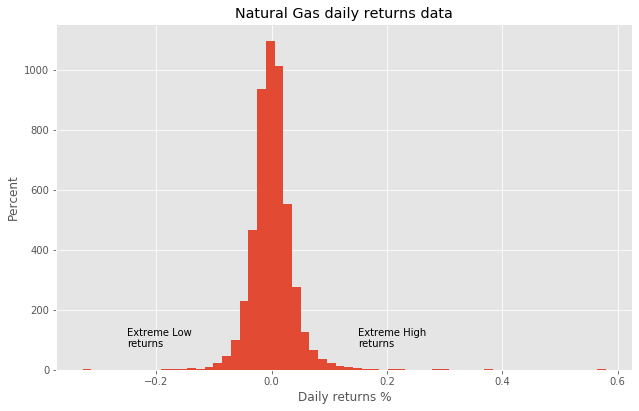



Maximum Drawdown
Maximum Daily Drawdown
Date
2000-01-04    0.000000
2000-01-05   -0.003676
2000-01-06    0.000000
2000-01-07   -0.010474
2000-01-10    0.000000
                ...   
2020-02-14   -0.358974
2020-02-18   -0.317741
2020-02-19   -0.318434
2020-02-20   -0.336105
2020-02-21   -0.339570
Name: Last, Length: 5048, dtype: float64


Min Daily Drawdown
Date
2000-01-04    0.000000
2000-01-05   -0.003676
2000-01-06   -0.003676
2000-01-07   -0.010474
2000-01-10   -0.010474
                ...   
2020-02-14   -0.559705
2020-02-18   -0.559705
2020-02-19   -0.559705
2020-02-20   -0.559705
2020-02-21   -0.559705
Name: Last, Length: 5048, dtype: float64




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

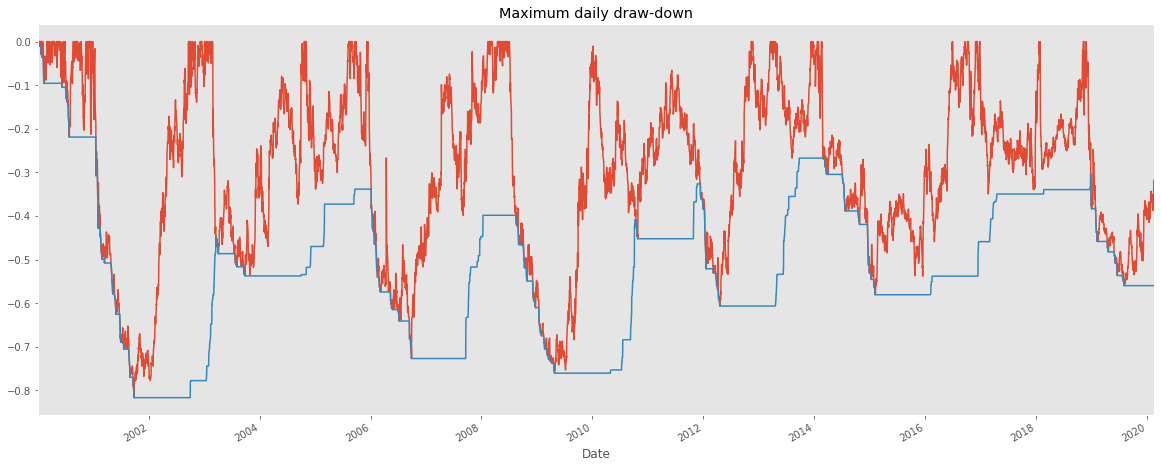



Probability of +/-(1%); +/-(3%); +/-%(5) change in gas prices (Data -> 2000- till date)
The probability of Henry Hub gas price changes between 1% and -1% is 28.53% 
The probability of Henry Hub gas price changes between 3% and -3% is 72.25% 
The probability of Henry Hub gas price changes between 5% and -5% is 89.30% 
The probability of Henry Hub gas price changes more than 5% is 5.88%
The probability of Henry Hub gas price changes less than -5% is 4.81%


Minimum Gas Prices so far [2000- till date]
1.626 2016-03-04 00:00:00
Maximum Gas Prices so far [2000- till date]
15.16 2005-12-14 00:00:00


Minimum Gas Prices so far- daily % return [2000- till date]
-0.32798226164079824 2006-04-17 00:00:00
Maximum Gas Prices so far- daily % return [2000- till date]
0.5802382620882973 2006-04-14 00:00:00


This is a classification variable, average price will go either up or down the next day.
The target variables transformed for binary classification. A positive change in the value of prices clas

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0]	validation_0-auc:0.919423	validation_1-auc:0.868598
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[10]	validation_0-auc:0.957168	validation_1-auc:0.925425
Stopping. Best iteration:
[14]	validation_0-auc:0.957406	validation_1-auc:0.932641

Model performance :: Quality of Classifier


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

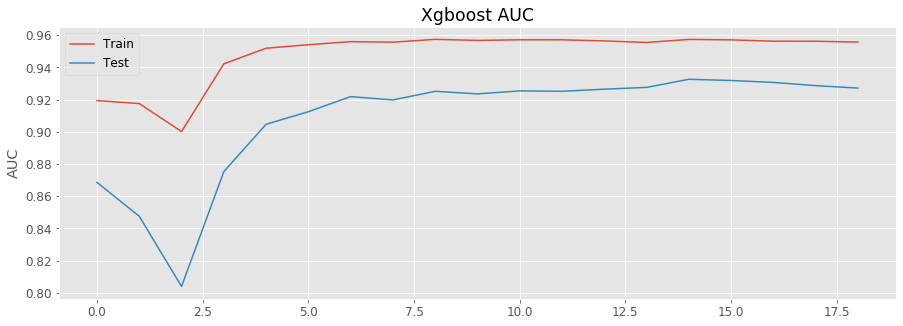

Next day Open price direction


<IPython.core.display.Javascript object>

     0
826  0
827  0
828  0
829  0
830  0
831  0
832  0
833  0
834  0
835  0
836  0
837  0
838  1
839  1
840  1


Area under ROC curve: 93.26409155937053




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

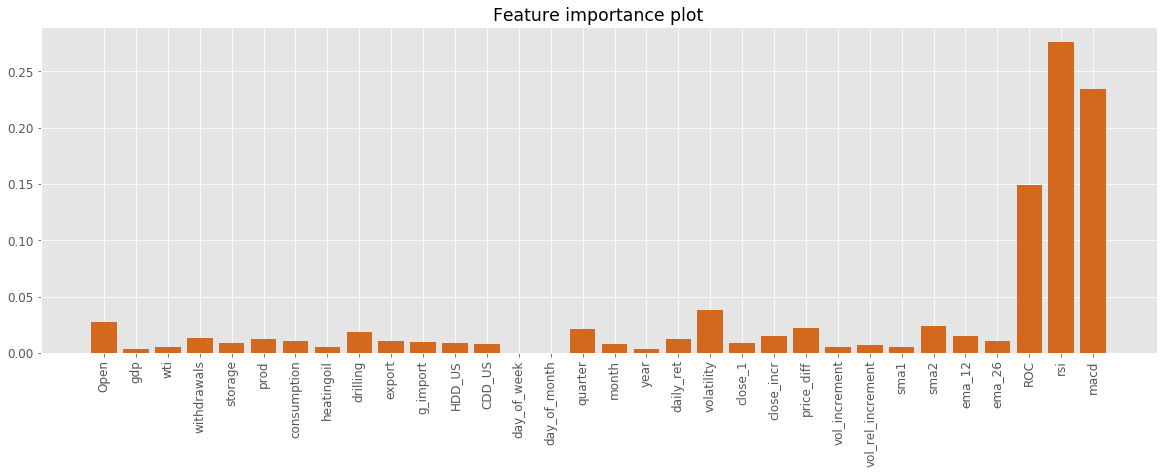



For each day where open price = 0 = red arrow head  and 1 = green arrow head 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

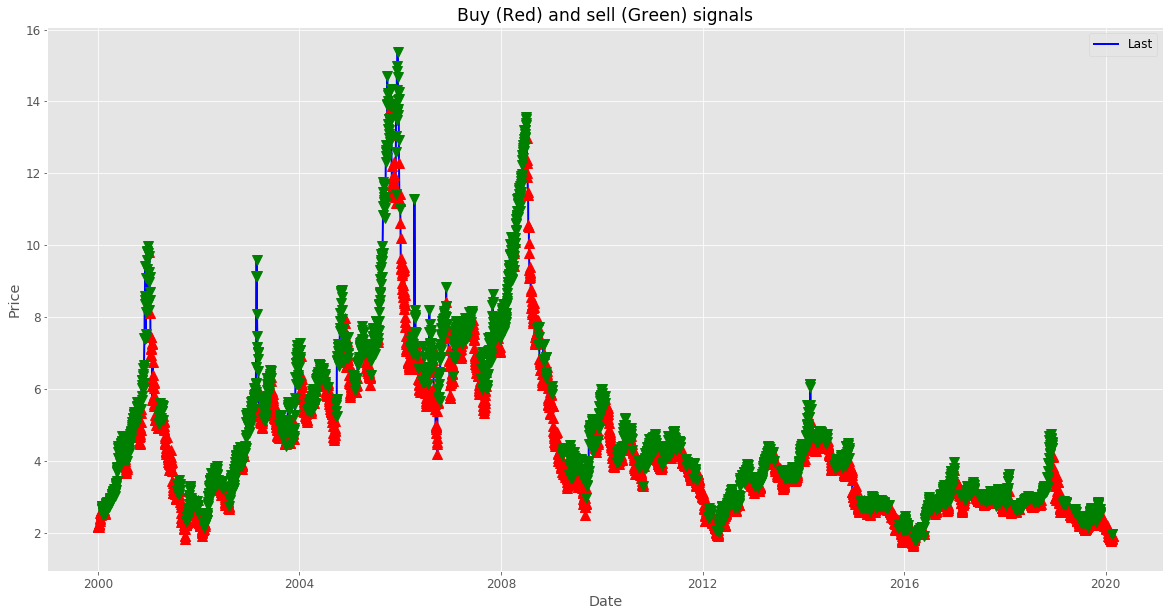



Average Sharpe Ratio (risk-adjusted return):: Daily
Sharpe Ratio: 0.01646330719200943
Sharpe Ratio:: Annual
Annualized Sharpe Ratio (risk-adjusted return): 0.2613468995263083




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0]	validation_0-auc:0.90369	validation_1-auc:0.462015
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[10]	validation_0-auc:0.996694	validation_1-auc:0.793612
[20]	validation_0-auc:0.996901	validation_1-auc:0.823211
Stopping. Best iteration:
[17]	validation_0-auc:0.997043	validation_1-auc:0.851879

Model performance :: Quality of Classifier


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

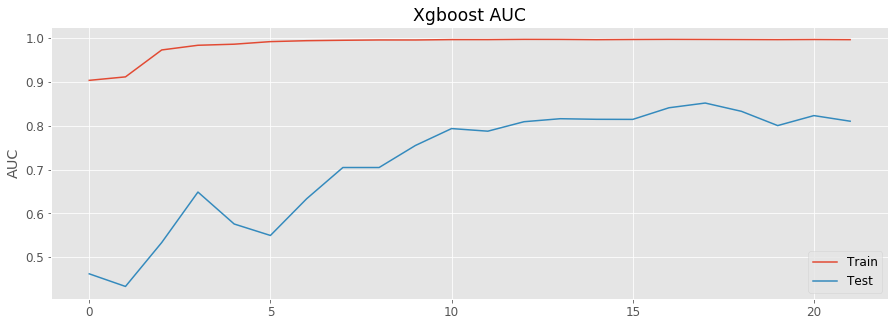

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

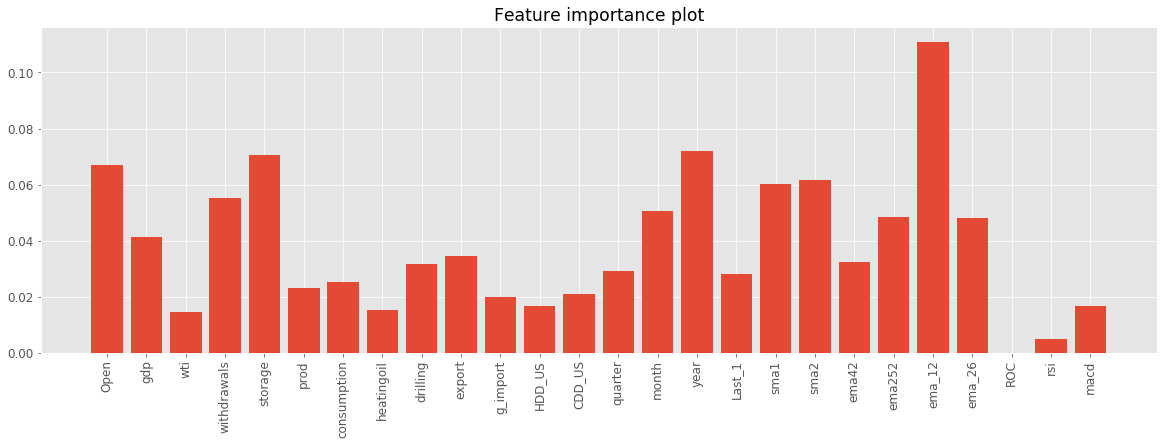



Area under ROC curve: 85.18787366460845


Next day Open price direction


<IPython.core.display.Javascript object>

     0
826  1
827  1
828  1
829  1
830  1
831  1
832  1
833  1
834  1
835  1
836  1
837  1
838  1
839  1
840  1


Simple Moving Average cross-over:: 1 is when short (42) crosses long, 0 is when long crosses short
Long moving average (252) down, the signal 1 [Buy] and when long (252) is up, the set signal 0 [Sell]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

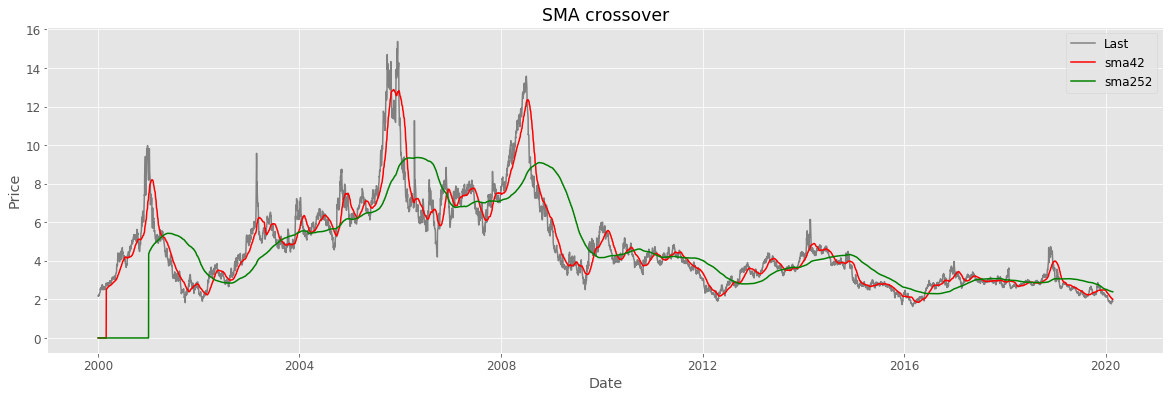



Natural Gas continuous contract 1
Print last 5 rows
           Date   Open   High    Low   Last    Volume
5043 2020-02-14  1.828  1.854  1.795  1.850  181598.0
5044 2020-02-18  1.880  1.983  1.874  1.969  299530.0
5045 2020-02-19  1.969  1.978  1.945  1.967  265032.0
5046 2020-02-20  1.967  2.025  1.907  1.916  260634.0
5047 2020-02-21  1.915  1.925  1.861  1.906  145333.0




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Backtesting
K-fold CV average score: 0.98


confidence:  0.9782724272372679


Expected Open price for next 5 days
[1.953147  1.9890956 2.0279894 2.0391665 1.9944286]


Natural Gas continuous contract 1
Print last 5 rows
           Date   Open   High    Low   Last    Volume
5043 2020-02-14  1.828  1.854  1.795  1.850  181598.0
5044 2020-02-18  1.880  1.983  1.874  1.969  299530.0
5045 2020-02-19  1.969  1.978  1.945  1.967  265032.0
5046 2020-02-20  1.967  2.025  1.907  1.916  260634.0
5047 2020-02-21  1.915  1.925  1.861  1.906  145333.0




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Backtesting
K-fold CV average score: 0.97


confidence:  0.9768516914403371


Expected Close price for next 5 days
[1.9672095 2.0392559 2.0158417 2.0170078 2.0055819]


Natural Gas continuous contract 1
Print 1st & last 5 rows
           Date   Open   High    Low   Last    Volume
0    2000-01-04  2.180  2.200  2.130  2.176   30152.0
1    2000-01-05  2.180  2.200  2.125  2.168   27946.0
2    2000-01-06  2.175  2.220  2.165  2.196   29071.0
3    2000-01-07  2.210  2.230  2.155  2.173   28455.0
4    2000-01-10  2.180  2.255  2.165  2.216   28916.0
...         ...    ...    ...    ...    ...       ...
5043 2020-02-14  1.828  1.854  1.795  1.850  181598.0
5044 2020-02-18  1.880  1.983  1.874  1.969  299530.0
5045 2020-02-19  1.969  1.978  1.945  1.967  265032.0
5046 2020-02-20  1.967  2.025  1.907  1.916  260634.0
5047 2020-02-21  1.915  1.925  1.861  1.906  145333.0

[5048 rows x 6 columns]


Feature engineering- Adding Weeks, Months and Year Columns
Print last 5 rows
           Date   Ope

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

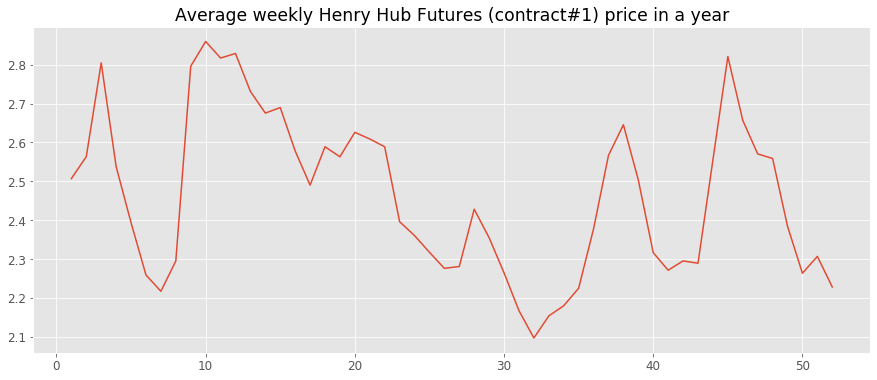

The plot reveals that, the average weekly Henry Hub Futures (Contract#1) price in a year illustrates mainly downward curve.


Average Weekly Gas Prices Pivot Table
Print last 5 rows


<IPython.core.display.Javascript object>

year      2000      2001    2002      2003     2004      2005     2006    2007     2008    2009     2010     2011     2012     2013    2014  \
week_no                                                                                                                                       
49       8.180  2.565000  4.2700  5.645000  7.59600  13.95560  7.76600  7.2260  6.37920  4.7386  4.45860  3.47740  3.60820  3.99500  3.8648   
50       8.354  2.734000  4.6290  6.727000  6.86280  14.59220  7.49000  7.1688  5.64600  4.9750  4.27840  3.21000  3.42040  4.27460  3.6822   
51       9.430  2.736000  5.2220  6.875000  7.15640  13.79240  6.90400  7.1066  5.63940  5.4750  4.12125  3.13420  3.36640  4.31380  3.7298   
52       9.455  2.813333  5.0725  6.233333  6.95125  11.36125  6.06125  7.0635  5.53925  5.7625  4.21020  3.09175  3.38875  4.45775  3.1895   
53         NaN       NaN     NaN       NaN  6.36375       NaN      NaN     NaN      NaN  5.8215      NaN      NaN      NaN      NaN     NaN   

<IPython.core.display.Javascript object>

year          2000      2001      2002      2003      2004       2005      2006      2007       2008      2009      2010      2011      2012  \
month_no                                                                                                                                       
1         2.385263  7.895714  2.215476  5.373810  6.367368   6.178650  9.225500  6.704045   7.976762  5.124400  5.612944  4.495150  2.727900   
2         2.599750  5.705789  2.256842  6.525000  5.353947   6.194895  7.675263  7.589750   8.598250  4.385944  5.266722  4.061947  2.527800   
3         2.818913  5.228409  2.969750  5.849762  5.526478   6.993909  6.969304  7.206955   9.644842  4.032455  4.342348  4.050591  2.315952   
4         3.025263  5.206000  3.424091  5.337381  5.769286   7.198810  7.472700  7.628350  10.248318  3.585905  4.092429  4.267737  2.064571   
5         3.560909  4.252955  3.564091  5.865000  6.370950   6.496667  6.402500  7.802783  11.384600  3.922600  4.141450  4.340619  2.49

In [5]:
!pip install pyforest
from pyforest import *
import datetime, pickle, copy
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
!pip install quandl
import quandl
!pip install mpl_finance
!pip install python_wtd
from python_wtd import WTD
plt.style.use('ggplot')
from statistics import variance 
from random import randint
import scipy as sp
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, roc_auc_score
from xgboost import XGBClassifier
!pip install fredapi
from fredapi import Fred
!pip install EIA_python
import eia
!pip install python_wtd
from python_wtd import WTD
!pip install termcolor
from termcolor import colored
from sklearn.model_selection import cross_val_score, KFold, cross_validate, train_test_split, TimeSeriesSplit
from xgboost import XGBRegressor
import xgboost as xgb


print('\033[4mNatural Gas continuous contract 1\033[0m')
NG = quandl.get("CHRIS/CME_NG1", authtoken="LSQpgUzwJRoF667ZpzyL") # natural gas continuous contract 1
NG = NG.loc['2000-01-01':,['Open', 'High', 'Low', 'Last', 'Volume']]
#print(NG)


# Cushing, OK WTI Spot Price FOB, Daily
print('\033[4mWTI Spot Price FOB, Daily (Dollars per Barrel)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    wti = pd.DataFrame(series_search)
    return wti

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='PET.RWTC.D'
      wti = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(wti))
      return wti;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

wti = main()
wti = wti.rename({'Cushing, OK WTI Spot Price FOB, Daily (Dollars per Barrel)': 'wti'}, axis = 'columns')
wti = wti.reset_index()
wti['index'] = pd.to_datetime(wti['index'].str[:-3], format='%Y %m%d')
wti['Date']= pd.to_datetime(wti['index']) 
wti.set_index('Date', inplace=True) # setting index column
wti = wti.loc['2000-01-01':,['wti']] # setting date range
wti = wti.astype(float)
#print(wti) 
#print('\n')

## GDP data
print('\033[4mUS GDP Data\033[0m')
fred = Fred(api_key='59c798fcda5850ef874412d269fd2378')
gdp = fred.get_series_as_of_date('GDP', '2020-01-31')
gdp = gdp.rename({'date': 'Date', 'value': 'gdp'}, axis = 'columns')
gdp.set_index('Date', inplace=True) # setting index column
gdp = gdp.loc['2000-01-01':'2020-02-02',['gdp']] # setting date range
gdp.replace({pd.NaT: "0"}, inplace=True) # replacing NaT with 0
gdp = gdp.ffill().bfill()
gdp = gdp.reset_index().drop_duplicates('Date').set_index('Date') # dropping duplicate concurrence
gdp = pd.DataFrame(gdp)
gdp = gdp.astype(float)
gdp = gdp.resample('B').ffill()
gdp = gdp/4
#print(gdp)
#print('\n')

# U.S. Natural Gas Marketed Production, Monthly
print('\033[4mNatural Gas Marketed Production, Monthly (Million Cubic Feet)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    prod = pd.DataFrame(series_search)
    return prod

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N9050US2.M'
      prod = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(prod))
      return prod;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

prod = main()
prod = prod.rename({'U.S. Natural Gas Marketed Production, Monthly (Million Cubic Feet)': 'prod'}, axis = 'columns')
prod = prod.reset_index()
prod['Date']= pd.to_datetime(prod['index']) 
prod.set_index('Date', inplace=True) # setting index column
prod = prod.loc['2000-01-01':,['prod']] # setting date range
prod = prod.astype(float)
prod = prod.resample('B').ffill()
prod = prod/21
#print(prod)
#print('\n')


# U.S. Natural Gas Gross Withdrawals, Monthly
print('\033[4mNatural Gas Gross Withdrawals, Monthly (Million Cubic Feet)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    withdrawals = pd.DataFrame(series_search)
    return withdrawals

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N9010US2.M' 
      withdrawals = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(withdrawals))
      return withdrawals;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

withdrawals = main()
withdrawals = withdrawals.rename({'U.S. Natural Gas Gross Withdrawals, Monthly (Million Cubic Feet)': 'withdrawals'}, axis = 'columns')
withdrawals = withdrawals.reset_index()
withdrawals['Date']= pd.to_datetime(withdrawals['index']) 
withdrawals.set_index('Date', inplace=True) # setting index column
withdrawals = withdrawals.loc['2000-01-01':,['withdrawals']] # setting date range
withdrawals = withdrawals.astype(float)
withdrawals = withdrawals.resample('B').bfill().ffill()
withdrawals = withdrawals/21
#print(withdrawals)
#print('\n')

# U.S. Natural Gas Underground Storage Volume, Monthly
print('\033[4mNatural Gas Underground Storage Volume, Monthly\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    storage = pd.DataFrame(series_search)
    return storage

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N5030US2.M '
      storage = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(storage))
      return storage;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

storage = main()
storage = storage.rename({'U.S. Natural Gas Underground Storage Volume, Monthly (Million Cubic Feet)': 'storage'}, axis = 'columns')
storage = storage.reset_index()
storage['Date']= pd.to_datetime(storage['index']) 
storage.set_index('Date', inplace=True) # setting index column
storage = storage.loc['2000-01-01':,['storage']] # setting date range
stoarge = storage.astype(float)
storage = storage.resample('B').bfill().ffill()
storage = storage/21
#print(storage)
#print('\n')

# U.S. Natural Gas Exports, Monthly
print('\033[4mNatural Gas Exports, Monthly (Million Cubic Feet)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    export = pd.DataFrame(series_search)
    return export

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N9133US2.M'
      export = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(export))
      return export;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

export = main()
export = export.rename({'Liquefied U.S. Natural Gas Exports, Monthly (Million Cubic Feet)': 'export'}, axis = 'columns')
export = export.reset_index()
export['Date']= pd.to_datetime(export['index']) 
export.set_index('Date', inplace=True) # setting index column
export = export.loc['2000-01-01':,['export']] # setting date range
export = export.astype(float)
export = export.resample('B').bfill().ffill()
export = export/21
#print(export)
#print('\n')

# natural gas total consumption (monthly))
print('\033[4mNatural Gas Total Consumption, Monthly (Million Cubic Feet)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    consumption = pd.DataFrame(series_search)
    return consumption

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N9140US2.M'
      consumption = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(consumption))
      return consumption;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

consumption = main()
consumption = consumption.rename({'U.S. Natural Gas Total Consumption, Monthly (Million Cubic Feet)': 'consumption'}, axis = 'columns')
consumption = consumption.reset_index()
consumption['Date']= pd.to_datetime(consumption['index']) 
consumption.set_index('Date', inplace=True) # setting index column
consumption = consumption.loc['2000-01-01':,['consumption']] # setting date range
consumption = consumption.astype(float)
consumption = consumption.resample('B').ffill().bfill()
consumption = consumption/21
#print(consumption)
#print('\n')

# New York Harbor No. 2 Heating Oil Spot Price FOB, Monthly
print('\033[4mHeating Oil Spot Price FOB, Daily (Dollars per Gallon)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    heatingoil = pd.DataFrame(series_search)
    return heatingoil

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='PET.EER_EPD2F_PF4_Y35NY_DPG.D'
      heatingoil = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(heatingoil))
      return heatingoil;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)

heatingoil = main()
heatingoil = heatingoil.rename({'New York Harbor No. 2 Heating Oil Spot Price FOB, Daily (Dollars per Gallon)': 'heatingoil'}, axis = 'columns')
heatingoil = heatingoil.reset_index()
heatingoil['index'] = pd.to_datetime(heatingoil['index'].str[:-3], format='%Y %m%d')
heatingoil['Date']= pd.to_datetime(heatingoil['index']) 
heatingoil.set_index('Date', inplace=True) # setting index column
heatingoil = heatingoil.loc['2000-01-01':,['heatingoil']] # setting date range
heatingoil = heatingoil.astype(float)
#print(heatingoil)
#print('\n')

# natural gas import dat
#print('\033[4mNatural Gas Imports, Monthly (Million Cubic Feet)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    g_import = pd.DataFrame(series_search)
    return g_import

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='NG.N9100US2.M'
      g_import = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(g_import))
      return g_import;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)
  
g_import = main()
g_import = g_import.rename({'U.S. Natural Gas Imports, Monthly (Million Cubic Feet)': 'g_import'}, axis = 'columns')
g_import = g_import.reset_index()
g_import['Date']= pd.to_datetime(g_import['index']) 
g_import.set_index('Date', inplace=True) # setting index column
g_import = g_import.loc['2000-01-01':,['g_import']] # setting date range
g_import = g_import.astype(float)
g_import = g_import.resample('B').ffill().bfill()
g_import = g_import/21
#print(g_import)
#print('\n')

# U.S. Natural Gas Rotary Rigs in Operation, Monthly
print('\033[4mNatural Gas Rotary Rigs in Operation, Monthly (Number of Elements)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    drilling = pd.DataFrame(series_search)
    return drilling

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='PET.E_ERTRRG_XR0_NUS_C.M '
      drilling = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(drilling))
      return drilling;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)
  
drilling = main()
drilling = drilling.rename({'U.S. Natural Gas Rotary Rigs in Operation, Monthly (Number of Elements)': 'drilling'}, axis = 'columns')
drilling = drilling.reset_index()
drilling['Date']= pd.to_datetime(drilling['index']) 
drilling.set_index('Date', inplace=True) # setting index column
drilling = drilling.loc['2000-01-01':,['drilling']] # setting date range
drilling = drilling.astype(float)
drilling = drilling.resample('B').ffill().bfill()
drilling = drilling/21
#print(drilling)
#print('\n')

# Heating Degree Days U.S. Average , Monthly
print('\033[4mHeating Degree Days U.S. Average , Monthly (total degree days)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    HDD_US = pd.DataFrame(series_search)
    return HDD_US

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='STEO.ZWHDPUS.M'
      HDD_US = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(HDD_US))
      return HDD_US;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)
  
HDD_US = main()
HDD_US = HDD_US.rename({'Heating Degree Days U.S. Average , Monthly (total degree days)': 'HDD_US'}, axis = 'columns')
HDD_US = HDD_US.reset_index()
HDD_US['Date']= pd.to_datetime(HDD_US['index']) 
HDD_US.set_index('Date', inplace=True) # setting index column
HDD_US = HDD_US.loc['2000-01-01':,['HDD_US']] # setting date range
HDD_US = HDD_US.astype(float)
HDD_US = HDD_US.resample('B').ffill().bfill()
HDD_US = HDD_US/21
#print(HDD_US)
#print('\n')

# Cooling Degree-Days, United States, Monthly
print('\033[4mCooling Degree-Days, United States, Monthly (Number)\033[0m')
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    CDD_US = pd.DataFrame(series_search)
    return CDD_US

def main():
    """
    Run main script
    """
    try:
      #Create EIA API using your specific API key
      api_key = "ad819ee5a69e69390eadf300fa168fa8"
      api = eia.API(api_key)
      #Declare desired series ID
      series_ID='TOTAL.ZWCDPUS.M'
      CDD_US = retrieve_time_series(api, series_ID)
      #Print the returned dataframe df
      print(type(CDD_US))
      return CDD_US;
    except Exception as e:
      print("error", e)
      return pd.DataFrame(columns=None)
  
CDD_US = main()
CDD_US = CDD_US.rename({'Cooling Degree-Days, United States, Monthly (Number)': 'CDD_US'}, axis = 'columns')
CDD_US = CDD_US.reset_index()
CDD_US['Date']= pd.to_datetime(CDD_US['index']) 
CDD_US.set_index('Date', inplace=True) # setting index column
CDD_US = CDD_US.loc['2000-01-01':,['CDD_US']] # setting date range
CDD_US = CDD_US.astype(float)
CDD_US = CDD_US.resample('B').ffill().bfill()
CDD_US = CDD_US/21
#print(CDD_US)
#print('\n')

# merging data frames
merge1 = NG.join(gdp, how='left').ffill().bfill()
merge2 = merge1.join(wti, how = 'left')
merge3 = merge2.join(withdrawals, how = 'left').ffill().bfill()
merge4 = merge3.join(storage, how = 'left').ffill().bfill()
merge5 = merge4.join(prod, how = 'left').ffill().bfill()
merge6 = merge5.join(consumption, how = 'left').ffill().bfill()
merge7 = merge6.join(heatingoil, how ='left').ffill().bfill()
merge8 = merge7.join(drilling, how = 'left').ffill().bfill()
merge9 = merge8.join(export, how = 'left').ffill().bfill()
merge10 = merge9.join(g_import, how = 'left').ffill().bfill()
merge11 = merge10.join(HDD_US, how = 'left').ffill().bfill()
merge12 = merge11.join(CDD_US, how = 'left').ffill().bfill()

# feature engineering
merge12['day_of_week'] = merge12.index.dayofweek
merge12['day_of_month'] = merge12.index.day
merge12['quarter'] = merge12.index.quarter
merge12['month'] = merge12.index.month
merge12['year'] = merge12.index.year

merge13 = merge12.apply(copy.deepcopy)
#print(merge13)

# Technical indicators
merge13['daily_ret'] = merge13['Last'].pct_change()
merge13['volatility'] = merge13['daily_ret'].rolling(252).std()*(252**0.5)
merge13["close_1"] = merge13['Last'].shift(1)
merge13["close_incr"] = merge13['Last'] - merge13['Last'].shift(1)
merge13['price_diff'] = merge13['Last'] - merge13['Open']
merge13["vol_increment"] = merge13['Volume'].diff()
merge13["vol_rel_increment"] = merge13['Volume'].diff() / merge13['Volume']

sma1 = 20
sma2 = 100
merge13["sma1"] = merge13['Last'].rolling(sma1).mean()
merge13["sma2"] = merge13['Last'].rolling(sma2).mean()
#merge13['ema42'] = merge13['Open'].ewm(span=42).mean()
#merge13['ema252'] = merge13['Open'].ewm(span=252).mean()

merge13['ema_12'] = merge13['Last'].ewm(span=10).mean()
merge13['ema_26'] = merge13['Last'].ewm(span=26).mean()
merge13['ROC'] = ((merge13['Last'] - merge13['Last'].shift(5)) / (merge13['Last'].shift(5)))*100

delta = merge13['Last'].diff()
window = 14
up_days = delta.copy()
up_days[delta<=0]=0.0
down_days = abs(delta.copy())
down_days[delta>0]=0.0
RS_up = up_days.rolling(window).mean()
RS_down = down_days.rolling(window).mean()
merge13['rsi'] = 100-100/(1+RS_up/RS_down)
merge13['macd'] = merge13['ema_12'] - merge13['ema_26']

#print('\033[4mMerged dataframe\033[0m')
#print(df.info())
#print('\n')


#print('\033[4mProcessed dataframe\033[0m')
df = merge13.apply(copy.deepcopy)
df.fillna(-99999, inplace=True)
#print(df)
#print(df.info())
#print('\n')

import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=NG.index,
                open=NG['Open'],
                high=NG['High'],
                low=NG['Low'],
                close=NG['Last'])])
fig.show()
print('\n')

#fig = plt.figure(figsize=(20,6))
#sns.lineplot(x='day_of_week', y= 'Open', data=df)
#plt.title('Natural gas continuous contract 1- day of the week opening price from 2000 to till date')
#plt.show()
#print('\n')

#fig = plt.figure(figsize=(20,6))
#sns.lineplot(x='month', y= 'Open', data=df);
#plt.title('Natural gas continuous contract 1- Monthly opening price from 2000 to till date', fontsize = 12)
#plt.show()
#print('\n')

# Calculate the daily percentage change which is daily return
#print('\033[1m' + 'daily percentage change' + '\033[1m')
daily_ret = merge13['Last'].pct_change().fillna(0)
mean_return = daily_ret.mean()
return_stdev = daily_ret.std()
print('Average daily return:',   mean_return )
print('Average Std deviation (Volatility):',  return_stdev)

print ('Annualized average return of Natural Gas (Contract#1):', round(mean_return * 252,2))
print('Annualized volatility of Natural Gas (Contract#1):', round(return_stdev * np.sqrt(252), 2))
print('\n')

#print('\033[4mStatistics summary\033[0m')
#print(merge12.daily_ret.describe())
#print('\n')

#print('\033[4mCritical Values\033[0m')
n = len(daily_ret)
test_statistic = ((daily_ret.mean() - 0) / (daily_ret.std()/np.sqrt(n)))
#print ('t test statistic: ', test_statistic)
#print('\n')

from scipy.stats import t
p_val = 2 * (1 - t.cdf(test_statistic, n - 1))
#print ('P-value is: ', p_val)
#print('\n')

from scipy.stats import chi2
# Here we calculate the critical value directly because our df is too high for most chisquare tables
crit_value = chi2.ppf(0.99, (n - 1))
#print ('Critical value at α = 0.01 with 251 df: ', crit_value)
#print('\n')

# +/- %5 daily change distribution in Henry Hub gas prices
#daily_ret.hist(bins=100, range = (-0.05, 0.05), figsize = (15,8))
#plt.title('+/- 5% daily change distribution in Henry Hub gas prices')
#plt.show()
#print('\n')

# Plot the distributions
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
daily_ret.plot.hist(bins = 60)
ax1.set_xlabel("Daily returns %")
ax1.set_ylabel("Percent")
ax1.set_title("Natural Gas daily returns data")
ax1.text(-0.25,75,"Extreme Low\nreturns")
ax1.text(0.15,75,"Extreme High\nreturns")
plt.show()
print('\n')
#print ('\033[1m' + 'Shapiro test: W-test, and P-value' + '\033[1m')
#print(stats.shapiro(daily_ret))
#print('\n')
#print("Skewness, Kurtosis : ", daily_ret.skew(), daily_ret.kurtosis())
#print('\n')
#print("T-value P-value (two-tail)")
#print(stats.ttest_1samp(daily_ret, 0.5))
#print(stats.ttest_1samp(daily_ret, 0))
#print('\n')

print('\033[4mMaximum Drawdown\033[0m')
# Using a trailing 252 trading day window
window = 252
# Calculate the max drawdown in the past window days for each day in the series.
# Using min_periods=1, we want to let the first 252 days data have an expanding window
roll_max = df['Last'].rolling(min_periods=1, window=window).max()
# Calculate daily draw-down from rolling max
daily_drawdown = df['Last']/roll_max - 1.0
print('\033[4mMaximum Daily Drawdown\033[0m')
print(daily_drawdown)
print('\n')

# Next we calculate the minimum (negative) daily drawdown in that window.
# using min_periods=1 to allow the expanding window
print('\033[4mMin Daily Drawdown\033[0m')
min_daily_drawdown = daily_drawdown.rolling(min_periods=1, window=window).min()
print(min_daily_drawdown)
print('\n')

# Plot the results
daily_drawdown.plot(figsize=(20,8))
min_daily_drawdown.plot()
plt.title('Maximum daily draw-down')
plt.grid()
plt.show()
print('\n')

print('\033[4mProbability of +/-(1%); +/-(3%); +/-%(5) change in gas prices (Data -> 2000- till date)\033[0m')
#print('\033[1m' + 'Probability of +/-(1%); +/-(3%); +/-%(5) change in gas prices (Data -> 2000- till date)' + '\033[1m')
print ("The probability of Henry Hub gas price changes between 1%% and -1%% is %1.2f%% " % 
       (100*daily_ret[(daily_ret > -0.01) & (daily_ret < 0.01)].shape[0] / daily_ret.shape[0]))
print ("The probability of Henry Hub gas price changes between 3%% and -3%% is %1.2f%% " % 
       (100*daily_ret[(daily_ret > -0.03) & (daily_ret < 0.03)].shape[0] / daily_ret.shape[0]))
print ("The probability of Henry Hub gas price changes between 5%% and -5%% is %1.2f%% " % 
       (100*daily_ret[(daily_ret > -0.05) & (daily_ret < 0.05)].shape[0] / daily_ret.shape[0]))
print ("The probability of Henry Hub gas price changes more than 5%% is %1.2f%%" % 
       (100*daily_ret[daily_ret > 0.05].shape[0] / daily_ret.shape[0]))
print ("The probability of Henry Hub gas price changes less than -5%% is %1.2f%%" % 
       (100*daily_ret[daily_ret < -0.05].shape[0] / daily_ret.shape[0]))
print('\n')

print('\033[4mMinimum Gas Prices so far [2000- till date]\033[0m')
print(df['Open'].min(), df['Open'].idxmin());
print('\033[4mMaximum Gas Prices so far [2000- till date]\033[0m')
print(df['Open'].max(), df['Open'].idxmax());
print('\n')

print('\033[4mMinimum Gas Prices so far- daily % return [2000- till date]\033[0m')
print(daily_ret.min(), daily_ret.idxmin()); 
print('\033[4mMaximum Gas Prices so far- daily % return [2000- till date]\033[0m')
print(daily_ret.max(), daily_ret.idxmax());
print('\n')

# Target Variable
print('\033[4mThis is a classification variable, average price will go either up or down the next day.\033[0m')
#This will be a classification variable, if the average price will go either up or down the next day.  
#The target will be forecasting the difference between today’s price and tomorrow’s price (which is unkonwn).
df['target'] = (df['sma1'].shift(-1) - df['sma1'])
df = df.fillna(0)
df['target'].tail()
#print('\n')

def getBinary(val):
    if val > 0:
      return 1
    else:
      return 0
df['next_day_direction'] = df["target"].apply(getBinary)
print('\033[4mThe target variables transformed for binary classification. A positive change in the value of prices classified as 1 and a non-positive change as 0.\033[0m')

#The target variables will be transformed for binary classification. 
#A positive change in the value of prices will be classified as 1 and a non-positive change as 0.
#print(df.tail())
#print('\n')

y = df['next_day_direction']
x = df.drop(columns = ['next_day_direction', 'target', 'Last', 'High', 'Low', 'Volume'])

X = np.array(x)
y = np.array(y)
tscv = TimeSeriesSplit()
#print(tscv)
TimeSeriesSplit(max_train_size=None, n_splits=5)
for train_index, test_index in tscv.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

eval_set = [(X_train, np.ravel(y_train)), (X_test, np.ravel(y_test))]
xgb_clf1 = XGBClassifier(learning_rate= 0.01,
                         max_depth= 5,
                         min_child_weight= 3,
                         n_estimators= 700,
                         subsample =1,
                         colsample_bytree = 0.5,
                         gamma = 1)
xgb_clf1.fit(X_train, y_train, 
             eval_metric = 'auc', eval_set = eval_set,
             early_stopping_rounds = 5, verbose = 10)

print('\033[4mModel performance :: Quality of Classifier\033[0m')
plt.rcParams['figure.figsize'] = 15, 5 
plt.rcParams['font.size'] = 12

history = xgb_clf1.evals_result_
x_axis = range(len(history['validation_0']['auc']))
plt.plot(x_axis, history['validation_0']['auc'], label = 'Train')
plt.plot(x_axis, history['validation_1']['auc'], label = 'Test')
plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

# we can then access the best number of tree and use it later for prediction
#print('best iteration', grad_clf.best_ntree_limit)
#print('\n')

# print the model's performance
ntree_limit = xgb_clf1.best_ntree_limit
print('\033[4mNext day Open price direction\033[0m')
pred = xgb_clf1.predict(X_test, ntree_limit = ntree_limit)
pred = pd.DataFrame(pred)
print(pred.tail(15))
print('\n')

pred_prob = xgb_clf1.predict_proba(X_test, ntree_limit = ntree_limit)[:, 1]
print('Area under ROC curve:', roc_auc_score(y_test, pred_prob)*100)
print('\n')

# Feature importance
fig = plt.figure(figsize=(20,6))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgb_clf1.feature_importances_))], xgb_clf1.feature_importances_.tolist(), 
        tick_label=x.columns, color="chocolate")
plt.title('Feature importance plot')
plt.show()
print('\n')

#print('\033[4mProbability of prediction results\033[0m')
#pred_prob = pd.DataFrame(pred_prob)
#print(pred_prob.tail(15))
#print('\n')


# For each day where open price > 0, we set the signal 1 means sell  and < 0, we set signal 0, to buy 
print('\033[4mFor each day where open price = 0 = red arrow head  and 1 = green arrow head \033[0m')
buys = df.loc[df['next_day_direction'] == 0]
sells = df.loc[df['next_day_direction'] == 1]

# Plot 
fig = plt.figure(figsize=(20,10))
plt.plot(df.index, df['Last'], color = 'b', lw=2., label='Last')
# Plot the buy and sell signals on the same plot
plt.plot(buys.index, df.loc[buys.index]['Last'], '^', markersize=10, color='r')
plt.plot(sells.index, df.loc[sells.index]['Last'], 'v', markersize=10, color='g')
plt.ylabel('Price')
plt.xlabel('Date')
plt.title('Buy (Red) and sell (Green) signals')
plt.legend(loc=0)
# Display everything
plt.show()
print('\n')

print('\033[4mAverage Sharpe Ratio (risk-adjusted return):: Daily\033[0m')
sharpe_ratio = daily_ret.mean() / daily_ret.std()
print('Sharpe Ratio:', sharpe_ratio)
print('\033[4mSharpe Ratio:: Annual\033[0m')
an_sharpe_ratio = (252**0.5) * sharpe_ratio # annualised sharpe ratio
print('Annualized Sharpe Ratio (risk-adjusted return):', an_sharpe_ratio)
print('\n')

## Moving averages crossover [2 months and 1 year look back]
merge14 = merge12.apply(copy.deepcopy)

# feature engineering
merge14['day_of_week'] = merge14.index.dayofweek
merge14['day_of_month'] = merge14.index.day
merge14['quarter'] = merge14.index.quarter
merge14['month'] = merge14.index.month
merge14['year'] = merge14.index.year

# Technical indicators
merge14['daily_ret'] = merge14['Last'].pct_change()
#merge14['volatility'] = merge14['daily_ret'].rolling(252).std()*(252**0.5)
merge14["Last_1"] = merge14['Last'].shift(1)
merge14["Last_incr"] = merge14['Last'] - merge14['Last'].shift(1)
merge14['price_diff'] = merge14['Last'] - merge14['Open']
merge14["vol_increment"] = merge14['Volume'].diff()
merge14["vol_rel_increment"] = merge14['Volume'].diff() / merge14['Volume']

sma1 = 42
sma2 = 252
merge14["sma1"] = merge14['Last'].rolling(sma1).mean().fillna(0)
merge14["sma2"] = merge14['Last'].rolling(sma2).mean().fillna(0)
merge14['ema42'] = merge14['Last'].ewm(span=42).mean().fillna(0)
merge14['ema252'] = merge14['Last'].ewm(span=252).mean().fillna(0)

merge14['ema_12'] = merge14['Last'].ewm(span=10).mean().fillna(0)
merge14['ema_26'] = merge14['Last'].ewm(span=26).mean().fillna(0)
merge14['ROC'] = ((merge14['Last'] - merge14['Last'].shift(5)) / (merge14['Last'].shift(5)))*100

delta = merge14['Last'].diff()
window = 14
up_days = delta.copy()
up_days[delta<=0]=0.0
down_days = abs(delta.copy())
down_days[delta>0]=0.0
RS_up = up_days.rolling(window).mean()
RS_down = down_days.rolling(window).mean()
merge14['rsi'] = 100-100/(1+RS_up/RS_down)
merge14['macd'] = merge14['ema_12'] - merge14['ema_26']


df1 = merge14.apply(copy.deepcopy)
df1.fillna(-99999, inplace=True)

# moving average crossover :: sma 252 is > sma 42
df1['target'] = np.where(df1['sma2'] > df1['sma1'], 1,0)
df1 = df1.fillna(0)
df1['target'].tail()
#print('\n')

def getBinary(val):
    if val>0:
        return 1
    else:
        return 0
df1['next_day_direction'] = df1["target"].apply(getBinary)

y1 = df1['next_day_direction']
x1 = df1.drop(columns = ['next_day_direction', 'target', 'Last', 'High', 'Low', 'Volume',
                         'day_of_week', 'day_of_month', 'daily_ret', 'Last_incr', 'price_diff',
                         'vol_increment', 'vol_rel_increment'])

X1 = np.array(x1)
y1 = np.array(y1)
tscv = TimeSeriesSplit()
#print(tscv)
TimeSeriesSplit(max_train_size=None, n_splits=5)
for train_index, test_index in tscv.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X1_train, X1_test = X1[train_index], X1[test_index]
  y1_train, y1_test = y1[train_index], y1[test_index]

eval_set = [(X1_train, np.ravel(y1_train)), (X1_test, np.ravel(y1_test))]

xgb_clf2 = XGBClassifier(learning_rate= 0.01,
                         max_depth= 5,
                         min_child_weight= 3,
                         n_estimators= 700,
                         subsample =1,
                         colsample_bytree = 0.5,
                         gamma = 1)
xgb_clf2.fit(X1_train, y1_train, 
            eval_metric = 'auc', eval_set = eval_set,
            early_stopping_rounds = 5, verbose = 10)

print('\033[4mModel performance :: Quality of Classifier\033[0m')
plt.rcParams['figure.figsize'] = 15, 5 
plt.rcParams['font.size'] = 12

history = xgb_clf2.evals_result_
x_axis = range(len(history['validation_0']['auc']))
plt.plot(x_axis, history['validation_0']['auc'], label = 'Train')
plt.plot(x_axis, history['validation_1']['auc'], label = 'Test')
plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

# we can then access the best number of tree and use it later for prediction
#print('best iteration', grad_clf.best_ntree_limit)
#print('\n')

# Feature importance
fig = plt.figure(figsize=(20,6))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgb_clf2.feature_importances_))], xgb_clf2.feature_importances_.tolist(), 
        tick_label=x1.columns)
plt.title('Feature importance plot')
plt.show()
print('\n')

#print('\033[4mProbability of prediction results\033[0m')
#pred_prob = pd.DataFrame(pred_prob)
#print(pred_prob.tail(15))
#print('\n')

# print the model's performance
ntree_limit = xgb_clf2.best_ntree_limit
prob = xgb_clf2.predict_proba(X1_test, ntree_limit = ntree_limit)[:, 1]
print('Area under ROC curve:', roc_auc_score(y1_test, prob)*100)
print('\n')

print('\033[4mNext day Open price direction\033[0m')
predict_prob2 = xgb_clf2.predict(X1_test, ntree_limit = ntree_limit)
predict_prob2 = pd.DataFrame(predict_prob2)
print(predict_prob2.tail(15))
print('\n')

print('\033[4mSimple Moving Average cross-over:: 1 is when short (42) crosses long, 0 is when long crosses short\033[0m')

print('\033[4mLong moving average (252) down, the signal 1 [Buy] and when long (252) is up, the set signal 0 [Sell]\033[0m')
buys = df1.loc[df1['next_day_direction'] == 0]
sells = df1.loc[df1['next_day_direction'] == 1]

# Plot 
fig = plt.figure(figsize=(20,6))
plt.plot(merge14['Last'], color='gray', label='Last')
# Plot the buy and sell signals on the same plot
plt.plot(merge14['sma1'].dropna(), color='r', label = 'sma42')
plt.plot(merge14['sma2'].dropna(), color='g', label = 'sma252')
plt.ylabel('Price')
plt.xlabel('Date')
plt.title('SMA crossover')
plt.legend(loc=0)
# Display everything
plt.show()
print('\n')

## 5 days look-ahead Open price

print('\033[4mNatural Gas continuous contract 1\033[0m')
print('\033[4mPrint last 5 rows\033[0m')
NG = quandl.get("CHRIS/CME_NG1", authtoken="LSQpgUzwJRoF667ZpzyL") # natural gas continuous contract 1
NG = NG.loc['2000-01-01':,['Open', 'High', 'Low', 'Last', 'Volume']]
NG.reset_index(level=0, inplace=True)
print(NG.tail())
print('\n')

# Technical indicators
merge16 = merge12.apply(copy.deepcopy)

merge16['pct_change'] = merge16['Open'].pct_change()
#merge16['volatility'] = merge16['pct_change'].rolling(252).std()*(252**0.5)
#merge16["vol_increment"] = merge16['Volume'].diff()
merge16["vol_rel_increment"] = merge16['Volume'].diff() / merge16['Volume']
merge16['std_5'] = merge16['pct_change'].rolling(5).std()
merge16['ret_5'] = merge16['pct_change'].rolling(5).mean()
merge16['sma42'] = merge16['Open'].rolling(42).mean()
#merge16["sma42_increment"] = merge16['sma42'].diff()  
merge16['sma252'] = merge16['Open'].rolling(252).mean()
#merge16["sma252_increment"] = merge16['sma252'].diff()
merge16['ema_12'] = merge16['Open'].ewm(span=10).mean()
merge16['ema_26'] = merge16['Open'].ewm(span=26).mean()
merge16['ROC'] = ((merge16['Open'] - merge16['Open'].shift(5)) / (merge16['Open'].shift(5)))*100

delta = merge16['Open'].diff()
window = 14
up_days = delta.copy()
up_days[delta<=0]=0.0
down_days = abs(delta.copy())
down_days[delta>0]=0.0
RS_up = up_days.rolling(window).mean()
RS_down = down_days.rolling(window).mean()
merge16['rsi'] = 100-100/(1+RS_up/RS_down)
merge16['macd'] = merge16['ema_12'] - merge16['ema_26']

df4 = merge16.apply(copy.deepcopy)
df4.fillna(-99999, inplace=True)
forecast_out = int(5) # predicting 5 days into future
df4['Prediction'] = df4[['Open']].shift(-forecast_out) #  label column with data shifted 21 units up

X3 = df4.drop(columns = ['Prediction', 'Last', 'High', 'Low', 'Volume'])
X3 = np.array(X3)
X3_forecast = X3[-forecast_out:] # set X_forecast equal to last 5, we do not have y values for X_forecast
X3 = X3[:-forecast_out] # remove last 7 from X
#df1.dropna(inplace=True)
y3 = np.array(df4['Prediction'])
y3 = y3[:-forecast_out]
df4.dropna(inplace=True)

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.2, random_state=42)

reg2 = xgb.XGBRegressor(objective ='reg:squarederror', n_jobs=-1)

# Create the model on train dataset
reg2.fit(X3_train, y3_train)

print('\033[4mBacktesting\033[0m')
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(reg2, X3_train, y3_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
print('\n')

confidence = reg2.score(X3_test, y3_test)
print("confidence: ", confidence)
print('\n')
forecast_pred_2 = reg2.predict(X3_forecast)
print('\033[4mExpected Open price for next 5 days\033[0m')
print(forecast_pred_2)
print('\n')


## 5 days look-ahead Close price
print('\033[4mNatural Gas continuous contract 1\033[0m')
print('\033[4mPrint last 5 rows\033[0m')
NG = quandl.get("CHRIS/CME_NG1", authtoken="LSQpgUzwJRoF667ZpzyL") # natural gas continuous contract 1
NG = NG.loc['2000-01-01':,['Open', 'High', 'Low', 'Last', 'Volume']]
NG.reset_index(level=0, inplace=True)
print(NG.tail())
print('\n')

# Technical indicators
merge15 = merge12.apply(copy.deepcopy)

merge15['pct_change'] = merge15['Last'].pct_change()
merge15['std_5'] = merge15['pct_change'].rolling(5).std()
merge15['ret_5'] = merge15['pct_change'].rolling(5).mean()
#merge15['volatility'] = merge15['pct_change'].rolling(252).std()*(252**0.5)
merge15['HL_pct'] = merge15['High'] - merge15['Low'] / merge15['Low']
merge15['price_diff'] = merge15['Last'] - merge15['Open']
#merge15["vol_increment"] = merge15['Volume'].diff()
merge15["vol_rel_increment"] = merge15['Volume'].diff() / merge15['Volume']
merge15['sma42'] = merge15['Last'].rolling(42).mean()
#merge15["sma42_increment"] = merge15['sma42'].diff() 
#merge15['sma252'] = merge15['Last'].rolling(252).mean()
#merge15["sma252_increment"] = merge15['sma252'].diff()
merge15['ema_12'] = merge15['Last'].ewm(span=10).mean()
merge15['ema_26'] = merge15['Last'].ewm(span=26).mean()
merge15['ROC'] = ((merge15['Last'] - merge15['Last'].shift(5)) / (merge15['Last'].shift(5)))*100

delta = merge14['Last'].diff()
window = 14
up_days = delta.copy()
up_days[delta<=0]=0.0
down_days = abs(delta.copy())
down_days[delta>0]=0.0
RS_up = up_days.rolling(window).mean()
RS_down = down_days.rolling(window).mean()
merge15['rsi'] = 100-100/(1+RS_up/RS_down)
merge15['macd'] = merge15['ema_12'] - merge15['ema_26']

df3 = merge15.apply(copy.deepcopy)
df3.fillna(-99999, inplace=True)
forecast_out = int(5) # predicting 5 days into future
df3['Prediction'] = df3[['Last']].shift(-forecast_out) #  label column with data shifted 21 units up

X2 = df3.drop(columns = ['Prediction', 'Open', 'High', 'Low', 'Volume'])
X2 = np.array(X2)
X2_forecast = X2[-forecast_out:] # set X1_forecast equal to last 5, we do not have y values for X_forecast
X2 = X2[:-forecast_out] # remove last 5 from X1
y2 = np.array(df3['Prediction'])
y2 = y2[:-forecast_out]
df1.dropna(inplace=True)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2, random_state=42)

reg1 = xgb.XGBRegressor(objective ='reg:squarederror', n_jobs=-1)

# Create the model on train dataset
reg1.fit(X2_train, y2_train)

print('\033[4mBacktesting\033[0m')
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(reg1, X2_train, y2_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
print('\n')

confidence = reg1.score(X2_test, y2_test)
print("confidence: ", confidence)
print('\n')
forecast_pred_1 = reg1.predict(X2_forecast)
print('\033[4mExpected Close price for next 5 days\033[0m')
print(forecast_pred_1)
print('\n')

# plotting the data
#df1['Forecast'] = np.nan

#last_date = df1.iloc[-1].name
#last_unix = last_date.timestamp()
#one_day = 86400
#next_unix = last_unix + one_day

#for i in forecast_pred_1:
  #next_date = datetime.datetime.fromtimestamp(next_unix)
  #next_unix += one_day
  #df1.loc[next_date] = [np.nan for _ in range(len(df1.columns)-1)] + [i]

#fig = plt.figure(figsize=(15,6))
#df1['Last'].plot()
#df1['Forecast'].plot()
#plt.legend(loc='best')
#plt.xlabel('Date')
#plt.ylabel('Price')
#plt.title('Historical & 30 days look-ahead line: Close price')
#plt.show()

#forecast_pred_1 = pd.DataFrame(forecast_pred_1)
#forecast_pred_1.rename(columns={0: "Pred Close price"}, inplace=True)
#forecast_pred_1

## Week, month, year historical analysis

print('\033[4mNatural Gas continuous contract 1\033[0m')
print('\033[4mPrint 1st & last 5 rows\033[0m')
NG = quandl.get("CHRIS/CME_NG1", authtoken="LSQpgUzwJRoF667ZpzyL") # natural gas continuous contract 1
NG = NG.loc['2000-01-01':,['Open', 'High', 'Low', 'Last', 'Volume']]
NG.reset_index(level=0, inplace=True)
print(NG)
print('\n')

# feature engineering
#Adding Weeks, Months and Year Columns
print('\033[4mFeature engineering- Adding Weeks, Months and Year Columns\033[0m')
print('\033[4mPrint last 5 rows\033[0m')
NG['week_no'] = NG['Date'].dt.week
NG['month_no'] = NG['Date'].dt.month
NG['year'] = NG['Date'].dt.year
NG['DayofWeek'] = NG['Date'].dt.dayofweek
print(NG.tail())
print('\n')

fig = plt.figure(figsize=(15,6))
plt.plot(NG[NG.year >= 2019].groupby('week_no')['Open'].mean().head(52))
plt.title('Average weekly Henry Hub Futures (contract#1) price in a year')
plt.show()
print ('\033[4mThe plot reveals that, the average weekly Henry Hub Futures (Contract#1) price in a year illustrates mainly downward curve.\033[0m')
print('\n')

# Average Weekly Gas Prices Pivot Table
print('\033[4mAverage Weekly Gas Prices Pivot Table\033[0m')
print('\033[4mPrint last 5 rows\033[0m')
pivot_ng = NG.pivot_table(values = 'Open', columns = ['year'], aggfunc= np.mean,index = ['week_no'])
print(pivot_ng.tail()) # last 5 rows
print('\n')

# Average Monthly Gas Prices & Percent Changes
print('\033[4mAverage Monthly Gas Prices\033[0m')
monthly = NG.pivot_table(values= 'Open', columns = ['year'],aggfunc = np.mean, index = ['month_no'])
print(monthly) 
print('\n')

monthly.loc[0] = monthly.loc[12,:].shift(1)
monthly.fillna(method='ffill', inplace=True) # filling nan values with previous data
monthly = monthly.sort_index()
print(monthly)
print('\n')

print('\033[4mAverage monthly gas prices % change\033[0m')
monthly_change = monthly.pct_change()
# dropping the 1st row
monthly_change = monthly_change.drop(monthly_change.index[0])
print(monthly_change)
print('\n')

print('\033[4mProbabilities of Monthly Gas Price Decline vs Raise\033[0m')
print('\033[4mProbability of gas price decline starts to increase by the summer months. It seems that fluctuations in gas price in the initial months of the year is rather high.\033[0m')
monthly_change['raise'] = monthly_change[(monthly_change.iloc
                                                              [:,:]>0)].count(axis=1)/(2020-2000)
monthly_change['decline'] = monthly_change[(monthly_change.iloc
                                                              [:,:]<0)].count(axis=1)/(2020-2000)   
print(monthly_change[['raise', 'decline']])  


# ***Extra for record***


## **Hyperparameter tunning [kept silent]**

In [0]:
# Hyperparameter optimization
#xgb = xgb_clf1.fit(X_train, y_train, early_stopping_rounds=50,  eval_metric="logloss", eval_set=[(X_test, y_test)])

# scores
#from  sklearn.metrics import log_loss
#log_train = log_loss(y_train, xgb.predict_proba(X_train)[:,1])
#log_valid = log_loss(y_test, xgb.predict_proba(X_test)[:,1])


#print('\n-----------------------')
#print('  logloss train: %.5f'%log_train)
#print('  logloss valid: %.5f'%log_valid)
#print('-----------------------')

#print('\nModel parameters...')
#print(xgb.get_params())

# **Moving averages crossover [2 months and 1 year look back]**

In [0]:
merge14 = merge12.apply(copy.deepcopy)

# feature engineering
merge14['day_of_week'] = merge14.index.dayofweek
merge14['day_of_month'] = merge14.index.day
merge14['quarter'] = merge14.index.quarter
merge14['month'] = merge14.index.month
merge14['year'] = merge14.index.year

# Technical indicators
merge14['daily_ret'] = merge14['Last'].pct_change()
#merge14['volatility'] = merge14['daily_ret'].rolling(252).std()*(252**0.5)
merge14["Last_1"] = merge14['Last'].shift(1)
merge14["Last_incr"] = merge14['Last'] - merge14['Last'].shift(1)
merge14['price_diff'] = merge14['Last'] - merge14['Open']
merge14["vol_increment"] = merge14['Volume'].diff()
merge14["vol_rel_increment"] = merge14['Volume'].diff() / merge14['Volume']

sma1 = 42
sma2 = 252
merge14["sma1"] = merge14['Last'].rolling(sma1).mean().fillna(0)
merge14["sma2"] = merge14['Last'].rolling(sma2).mean().fillna(0)
merge14['ema42'] = merge14['Last'].ewm(span=42).mean().fillna(0)
merge14['ema252'] = merge14['Last'].ewm(span=252).mean().fillna(0)

merge14['ema_12'] = merge14['Last'].ewm(span=10).mean().fillna(0)
merge14['ema_26'] = merge14['Last'].ewm(span=26).mean().fillna(0)
merge14['ROC'] = ((merge14['Last'] - merge14['Last'].shift(5)) / (merge14['Last'].shift(5)))*100

delta = merge14['Last'].diff()
window = 14
up_days = delta.copy()
up_days[delta<=0]=0.0
down_days = abs(delta.copy())
down_days[delta>0]=0.0
RS_up = up_days.rolling(window).mean()
RS_down = down_days.rolling(window).mean()
merge14['rsi'] = 100-100/(1+RS_up/RS_down)
merge14['macd'] = merge14['ema_12'] - merge14['ema_26']


df1 = merge14.apply(copy.deepcopy)
df1.fillna(-99999, inplace=True)

# moving average crossover :: sma 252 is > sma 42
df1['target'] = np.where(df1['sma2'] > df1['sma1'], 1,0)
df1 = df1.fillna(0)
df1['target'].tail()
#print('\n')

def getBinary(val):
    if val>0:
        return 1
    else:
        return 0
df1['next_day_direction'] = df1["target"].apply(getBinary)

y1 = df1['next_day_direction']
x1 = df1.drop(columns = ['next_day_direction', 'target', 'Last', 'High', 'Low', 'Volume',
                         'day_of_week', 'day_of_month', 'daily_ret', 'Last_incr', 'price_diff',
                         'vol_increment', 'vol_rel_increment'])

X1 = np.array(x1)
y1 = np.array(y1)
tscv = TimeSeriesSplit()
#print(tscv)
TimeSeriesSplit(max_train_size=None, n_splits=5)
for train_index, test_index in tscv.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X1_train, X1_test = X1[train_index], X1[test_index]
  y1_train, y1_test = y1[train_index], y1[test_index]

eval_set = [(X1_train, np.ravel(y1_train)), (X1_test, np.ravel(y1_test))]

xgb_clf2 = XGBClassifier(learning_rate= 0.01,
                         max_depth= 5,
                         min_child_weight= 3,
                         n_estimators= 700,
                         subsample =1,
                         colsample_bytree = 0.5,
                         gamma = 1)
xgb_clf2.fit(X1_train, y1_train, 
            eval_metric = 'auc', eval_set = eval_set,
            early_stopping_rounds = 5, verbose = 10)

print('\033[4mModel performance :: Quality of Classifier\033[0m')
plt.rcParams['figure.figsize'] = 15, 5 
plt.rcParams['font.size'] = 12

history = xgb_clf2.evals_result_
x_axis = range(len(history['validation_0']['auc']))
plt.plot(x_axis, history['validation_0']['auc'], label = 'Train')
plt.plot(x_axis, history['validation_1']['auc'], label = 'Test')
plt.legend(loc = 'best')
plt.ylabel('AUC')
plt.title('Xgboost AUC')
plt.show()

# we can then access the best number of tree and use it later for prediction
#print('best iteration', grad_clf.best_ntree_limit)
#print('\n')

# Feature importance
fig = plt.figure(figsize=(20,6))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgb_clf2.feature_importances_))], xgb_clf2.feature_importances_.tolist(), 
        tick_label=x1.columns)
plt.title('Feature importance plot')
plt.show()
print('\n')

#print('\033[4mProbability of prediction results\033[0m')
#pred_prob = pd.DataFrame(pred_prob)
#print(pred_prob.tail(15))
#print('\n')

# print the model's performance
ntree_limit = xgb_clf2.best_ntree_limit
prob = xgb_clf2.predict_proba(X1_test, ntree_limit = ntree_limit)[:, 1]
print('Area under ROC curve:', roc_auc_score(y1_test, prob)*100)
print('\n')

print('\033[4mNext day Open price direction\033[0m')
predict_prob2 = xgb_clf2.predict(X1_test, ntree_limit = ntree_limit)
predict_prob2 = pd.DataFrame(predict_prob2)
print(predict_prob2.tail(15))
print('\n')

print('\033[4mSimple Moving Average cross-over:: 1 is when short (42) crosses long, 0 is when long crosses short\033[0m')

print('\033[4mLong moving average (252) down, the signal 1 [Buy] and when long (252) is up, the set signal 0 [Sell]\033[0m')
buys = df1.loc[df1['next_day_direction'] == 0]
sells = df1.loc[df1['next_day_direction'] == 1]

# Plot 
fig = plt.figure(figsize=(20,6))
plt.plot(merge14['Last'], color='gray', label='Last')
# Plot the buy and sell signals on the same plot
plt.plot(merge14['sma1'].dropna(), color='r', label = 'sma42')
plt.plot(merge14['sma2'].dropna(), color='g', label = 'sma252')
plt.ylabel('Price')
plt.xlabel('Date')
plt.title('SMA crossover')
plt.legend(loc=0)
# Display everything
plt.show()

# **Hyperparameter tunning [kept silent]**

In [0]:
# Hyperparameter optimization
#xgb = grad_clf.fit(train_x, train_y, early_stopping_rounds=50,  eval_metric="logloss", eval_set=[(test_x, test_y)])

# scores
#from  sklearn.metrics import log_loss
#log_train = log_loss(train_y, xgb.predict_proba(train_x)[:,1])
#log_valid = log_loss(test_y, xgb.predict_proba(test_x)[:,1])


#print('\n-----------------------')
#print('  logloss train: %.5f'%log_train)
#print('  logloss valid: %.5f'%log_valid)
#print('-----------------------')

#print('\nModel parameters...')
#print(xgb.get_params())

#**5 days look-ahead Open price**

In [0]:
print('\033[4mNatural Gas continuous contract 1\033[0m')
print('\033[4mPrint last 5 rows\033[0m')
NG = quandl.get("CHRIS/CME_NG1", authtoken="LSQpgUzwJRoF667ZpzyL") # natural gas continuous contract 1
NG = NG.loc['2000-01-01':,['Open', 'High', 'Low', 'Last', 'Volume']]
NG.reset_index(level=0, inplace=True)
print(NG.tail())
print('\n')

# Technical indicators
merge16 = merge12.apply(copy.deepcopy)

merge16['pct_change'] = merge16['Open'].pct_change()
#merge16['volatility'] = merge16['pct_change'].rolling(252).std()*(252**0.5)
#merge16["vol_increment"] = merge16['Volume'].diff()
merge16["vol_rel_increment"] = merge16['Volume'].diff() / merge16['Volume']
merge16['std_5'] = merge16['pct_change'].rolling(5).std()
merge16['ret_5'] = merge16['pct_change'].rolling(5).mean()
merge16['sma42'] = merge16['Open'].rolling(42).mean()
#merge16["sma42_increment"] = merge16['sma42'].diff()  
merge16['sma252'] = merge16['Open'].rolling(252).mean()
#merge16["sma252_increment"] = merge16['sma252'].diff()
merge16['ema_12'] = merge16['Open'].ewm(span=10).mean()
merge16['ema_26'] = merge16['Open'].ewm(span=26).mean()
merge16['ROC'] = ((merge16['Open'] - merge16['Open'].shift(5)) / (merge16['Open'].shift(5)))*100

delta = merge16['Open'].diff()
window = 14
up_days = delta.copy()
up_days[delta<=0]=0.0
down_days = abs(delta.copy())
down_days[delta>0]=0.0
RS_up = up_days.rolling(window).mean()
RS_down = down_days.rolling(window).mean()
merge16['rsi'] = 100-100/(1+RS_up/RS_down)
merge16['macd'] = merge16['ema_12'] - merge16['ema_26']

df4 = merge16.apply(copy.deepcopy)
df4.fillna(-99999, inplace=True)
forecast_out = int(5) # predicting 5 days into future
df4['Prediction'] = df4[['Open']].shift(-forecast_out) #  label column with data shifted 21 units up

X3 = df4.drop(columns = ['Prediction', 'Last', 'High', 'Low', 'Volume'])
X3 = np.array(X3)
X3_forecast = X3[-forecast_out:] # set X_forecast equal to last 5, we do not have y values for X_forecast
X3 = X3[:-forecast_out] # remove last 7 from X
#df1.dropna(inplace=True)
y3 = np.array(df4['Prediction'])
y3 = y3[:-forecast_out]
df4.dropna(inplace=True)

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.2, random_state=42)

reg2 = xgb.XGBRegressor(objective ='reg:squarederror', n_jobs=-1)

# Create the model on train dataset
reg2.fit(X3_train, y3_train)

print('\033[4mBacktesting\033[0m')
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(reg2, X3_train, y3_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
print('\n')

confidence = reg2.score(X3_test, y3_test)
print("confidence: ", confidence)
print('\n')
forecast_pred_2 = reg2.predict(X3_forecast)
print('\033[4mExpected Open price for next 5 days\033[0m')
print(forecast_pred_2)


# **5 days look-ahead Close price**

In [0]:
print('\033[4mNatural Gas continuous contract 1\033[0m')
print('\033[4mPrint last 5 rows\033[0m')
NG = quandl.get("CHRIS/CME_NG1", authtoken="LSQpgUzwJRoF667ZpzyL") # natural gas continuous contract 1
NG = NG.loc['2000-01-01':,['Open', 'High', 'Low', 'Last', 'Volume']]
NG.reset_index(level=0, inplace=True)
print(NG.tail())
print('\n')

# Technical indicators
merge15 = merge12.apply(copy.deepcopy)

merge15['pct_change'] = merge15['Last'].pct_change()
merge15['std_5'] = merge15['pct_change'].rolling(5).std()
merge15['ret_5'] = merge15['pct_change'].rolling(5).mean()
#merge15['volatility'] = merge15['pct_change'].rolling(252).std()*(252**0.5)
merge15['HL_pct'] = merge15['High'] - merge15['Low'] / merge15['Low']
merge15['price_diff'] = merge15['Last'] - merge15['Open']
#merge15["vol_increment"] = merge15['Volume'].diff()
merge15["vol_rel_increment"] = merge15['Volume'].diff() / merge15['Volume']
merge15['sma42'] = merge15['Last'].rolling(42).mean()
#merge15["sma42_increment"] = merge15['sma42'].diff() 
#merge15['sma252'] = merge15['Last'].rolling(252).mean()
#merge15["sma252_increment"] = merge15['sma252'].diff()
merge15['ema_12'] = merge15['Last'].ewm(span=10).mean()
merge15['ema_26'] = merge15['Last'].ewm(span=26).mean()
merge15['ROC'] = ((merge15['Last'] - merge15['Last'].shift(5)) / (merge15['Last'].shift(5)))*100

delta = merge14['Last'].diff()
window = 14
up_days = delta.copy()
up_days[delta<=0]=0.0
down_days = abs(delta.copy())
down_days[delta>0]=0.0
RS_up = up_days.rolling(window).mean()
RS_down = down_days.rolling(window).mean()
merge15['rsi'] = 100-100/(1+RS_up/RS_down)
merge15['macd'] = merge15['ema_12'] - merge15['ema_26']

df3 = merge15.apply(copy.deepcopy)
df3.fillna(-99999, inplace=True)
forecast_out = int(5) # predicting 5 days into future
df3['Prediction'] = df3[['Last']].shift(-forecast_out) #  label column with data shifted 21 units up

X2 = df3.drop(columns = ['Prediction', 'Open', 'High', 'Low', 'Volume'])
X2 = np.array(X2)
X2_forecast = X2[-forecast_out:] # set X1_forecast equal to last 5, we do not have y values for X_forecast
X2 = X2[:-forecast_out] # remove last 5 from X1
y2 = np.array(df3['Prediction'])
y2 = y2[:-forecast_out]
df1.dropna(inplace=True)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2, random_state=42)

reg1 = xgb.XGBRegressor(objective ='reg:squarederror', n_jobs=-1)

# Create the model on train dataset
reg1.fit(X2_train, y2_train)

print('\033[4mBacktesting\033[0m')
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(reg1, X2_train, y2_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
print('\n')

confidence = reg1.score(X2_test, y2_test)
print("confidence: ", confidence)
print('\n')
forecast_pred_1 = reg1.predict(X2_forecast)
print('\033[4mExpected Close price for next 5 days\033[0m')
print(forecast_pred_1)

# plotting the data
#df1['Forecast'] = np.nan

#last_date = df1.iloc[-1].name
#last_unix = last_date.timestamp()
#one_day = 86400
#next_unix = last_unix + one_day

#for i in forecast_pred_1:
  #next_date = datetime.datetime.fromtimestamp(next_unix)
  #next_unix += one_day
  #df1.loc[next_date] = [np.nan for _ in range(len(df1.columns)-1)] + [i]

#fig = plt.figure(figsize=(15,6))
#df1['Last'].plot()
#df1['Forecast'].plot()
#plt.legend(loc='best')
#plt.xlabel('Date')
#plt.ylabel('Price')
#plt.title('Historical & 30 days look-ahead line: Close price')
#plt.show()

#forecast_pred_1 = pd.DataFrame(forecast_pred_1)
#forecast_pred_1.rename(columns={0: "Pred Close price"}, inplace=True)
#forecast_pred_1


#**Week, month, year historical analysis**

In [0]:
print('\033[4mNatural Gas continuous contract 1\033[0m')
print('\033[4mPrint 1st & last 5 rows\033[0m')
NG = quandl.get("CHRIS/CME_NG1", authtoken="LSQpgUzwJRoF667ZpzyL") # natural gas continuous contract 1
NG = NG.loc['2000-01-01':,['Open', 'High', 'Low', 'Last', 'Volume']]
NG.reset_index(level=0, inplace=True)
print(NG)
print('\n')

# feature engineering
#Adding Weeks, Months and Year Columns
print('\033[4mFeature engineering- Adding Weeks, Months and Year Columns\033[0m')
print('\033[4mPrint last 5 rows\033[0m')
NG['week_no'] = NG['Date'].dt.week
NG['month_no'] = NG['Date'].dt.month
NG['year'] = NG['Date'].dt.year
NG['DayofWeek'] = NG['Date'].dt.dayofweek
print(NG.tail())
print('\n')

fig = plt.figure(figsize=(15,6))
plt.plot(NG[NG.year >= 2019].groupby('week_no')['Open'].mean().head(52))
plt.title('Average weekly Henry Hub Futures (contract#1) price in a year')
plt.show()
print ('\033[4mThe plot reveals that, the average weekly Henry Hub Futures (Contract#1) price in a year illustrates mainly downward curve.\033[0m')
print('\n')

# Average Weekly Gas Prices Pivot Table
print('\033[4mAverage Weekly Gas Prices Pivot Table\033[0m')
print('\033[4mPrint last 5 rows\033[0m')
pivot_ng = NG.pivot_table(values = 'Open', columns = ['year'], aggfunc= np.mean,index = ['week_no'])
print(pivot_ng.tail()) # last 5 rows
print('\n')

# Average Monthly Gas Prices & Percent Changes
print('\033[4mAverage Monthly Gas Prices\033[0m')
monthly = NG.pivot_table(values= 'Open', columns = ['year'],aggfunc = np.mean, index = ['month_no'])
print(monthly) 
print('\n')

monthly.loc[0] = monthly.loc[12,:].shift(1)
monthly.fillna(method='ffill', inplace=True) # filling nan values with previous data
monthly = monthly.sort_index()
print(monthly)
print('\n')

print('\033[4mAverage monthly gas prices % change\033[0m')
monthly_change = monthly.pct_change()
# dropping the 1st row
monthly_change = monthly_change.drop(monthly_change.index[0])
print(monthly_change)
print('\n')

print('\033[4mProbabilities of Monthly Gas Price Decline vs Raise\033[0m')
print('\033[4mProbability of gas price decline starts to increase by the summer months. It seems that fluctuations in gas price in the initial months of the year is rather high.\033[0m')
monthly_change['raise'] = monthly_change[(monthly_change.iloc
                                                              [:,:]>0)].count(axis=1)/(2020-2000)
monthly_change['decline'] = monthly_change[(monthly_change.iloc
                                                              [:,:]<0)].count(axis=1)/(2020-2000)   
print(monthly_change[['raise', 'decline']])  

In [0]:
#print('Memory occupied before downcasting:',initial.sum())
#print('Memory occupied after downcasting :',market_data.memory_usage().sum())
#print('Total memory saved                :',round(market_data.memory_usage().sum()*100/initial.sum(), 2),'%')

In [0]:
!pip install dash dash-core-components dash-html-components
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import dash_table
!pip install jupyter_plotly_dash
from jupyter_plotly_dash import JupyterDash
!pip install plotly
import plotly.graph_objects as go

#monthly_change = monthly_change.reset_index()
#monthly = monthly.reset_index()
#pivot_ng = pivot_ng.reset_index()


#combine data of expected open and close prices
expected_values= np.array([forecast_pred_2, forecast_pred_1])
expected = pd.DataFrame({'Open':expected_values[0,:],'Close':expected_values[1,:]})
print(expected)
print(type(expected))
app = JupyterDash(__name__)
#app.config['suppress_callback_exceptions'] = True


colors = {
    'background': '#111222',
    'text': '#7FDBFF'
}


app.layout=html.Div(
    [
        dcc.Interval(
                    id='intervalNG',
                    interval = 1*50000,
                    n_intervals=0
                                      
                ),
        html.Div(
            children='Natural Gas Dashboard',
            style={
                        'textAlign': 'center',
                        'color': colors['text'],
                        'fontSize':45,
                        'background': '#111222'
                        }
            
            ),
              
        html.Div(
            [
                html.Div(
            [
               dcc.Graph(id='NaturalGas')
                
                ],
                style={'width': '100%', 'display': 'inline-block'},
                ),
                html.Div(
                    [
                         dcc.Graph(id='DailyDrawdown')                        
                        
                        
                    ],
                style={'width': '100%', 'display': 'inline-block'},
                ),
                
                html.Div(
                    [
                         dcc.Graph(id='SMACrossover')                        
                        
                        
                    ],
                style={'width': '100%', 'display': 'inline-block'},
                ),
                
                 html.Div(
                     [
                     html.Div(
                         
                    [
                         dcc.Graph(id='BuysSells')                        
                        
                        
                    ],
                style={'width': '48%', 'display': 'inline-block','marginRight':'20px','marginTop':'10px','height':'35%'},
                     
                     ),
                     
                    html.Div(
                         
                    [
                         dcc.Graph(id='NGdailyreturns')                        
                        
                        
                    ],
                style={'width': '48%', 'display': 'inline-block','marginTop':'10px','marginLeft':'10px','height':'35%'},
                     
                     ),
                 ]),
                html.Div(
                
                    children='Average Weekly Gas Prices Pivot Table',
                    style={
                        'textAlign': 'center',
                        'color': colors['text'],
                        'fontSize':30,
                        'background': '#111222'
                        }
                ),
                html.Div(
                [
                    dash_table.DataTable(
                        id='pivot_ng',
                        columns=(
                        [{"name": i, "id": i} for i in pivot_ng.tail().columns]
                        ),
                        data=((pivot_ng.tail().round(3)).to_dict('records')),
                        style_header={'backgroundColor': 'rgb(30, 30, 30)',
                                      'fontWeight':'bold',
                                      'color': colors['text']},
                        style_cell={
                            'backgroundColor': 'rgb(50, 50, 50)',
                            'color': colors['text']
                        },
                    )
                ],
               ),
                
                html.Div(
                
                    children='Average Monthly Gas Prices',
                    style={
                        'textAlign': 'center',
                        'color': colors['text'],
                        'fontSize':30,
                        'background': '#111222'
                        }
                ),
                html.Div(
                [
                    dash_table.DataTable(
                        id='month',
                        columns=(
                        [{"name": i, "id": i} for i in monthly.columns]
                        ),
                        data=((monthly.tail().round(3)).to_dict('records')),
                        style_header={'backgroundColor': 'rgb(30, 30, 30)',
                                      'fontWeight':'bold',
                                      'color': colors['text']},
                        style_cell={
                            'backgroundColor': 'rgb(50, 50, 50)',
                            'color': colors['text']
                        },
                        page_action="native",
                        page_current= 0,
                        page_size= 10,
                    )
                ],
               ),
                
                html.Div(
                
                    children='Average monthly gas prices % change',
                    style={
                        'textAlign': 'center',
                        'color': colors['text'],
                        'fontSize':30,
                        'background': '#111222'
                        }
                ),
                html.Div(
                [
                    dash_table.DataTable(
                        id='monthly_change',
                        columns=(
                        [{"name": i, "id": i} for i in monthly_change.columns]
                        ),
                        data=((monthly_change.tail().round(3)).to_dict('records')),
                        style_header={'backgroundColor': 'rgb(30, 30, 30)',
                                      'fontWeight':'bold',
                                      'color': colors['text']},
                        style_cell={
                            'backgroundColor': 'rgb(50, 50, 50)',
                            'color': colors['text']
                        },
                        page_action="native",
                        page_current= 0,
                        page_size= 10,
                    )
                ],
                ),
                
                html.Div(
                [
                    html.Div(
                    [
                         html.Div(
                
                    children='Probabilities of Monthly Gas Price Decline vs Raise',
                    style={
                        'textAlign': 'center',
                        'color': colors['text'],
                        'fontSize':30,
                        'background': '#111222'
                        }
                ),
                html.Div(
                [
                    dash_table.DataTable(
                        id='raise_decline',
                        columns=(
                        [{"name": 'Month', "id": 'month_no'},
                         {"name": 'Raise', "id": 'raise'},
                         {"name": 'Decline', "id": 'decline'},
                        ]
                        ),
                        data=(monthly_change.to_dict('records')),
                        style_header={'backgroundColor': 'rgb(30, 30, 30)',
                                      'fontWeight':'bold',
                                      'color': colors['text']},
                        style_cell={
                            'backgroundColor': 'rgb(50, 50, 50)',
                            'color': colors['text']
                        },
                         page_action="native",
                         page_current= 0,
                         page_size= 5,
                       
                    )
                ],
                )
                    ],
                    style={'width': '48%', 'display': 'inline-block','marginTop':'10px','marginLeft':'10px','height':'35%'},
                    ),
                    
                    
                    
                    ##############
                    
                    html.Div(
                    [
                         html.Div(
                
                    children='5 Days look-ahead Open/Close price',
                    style={
                        'textAlign': 'center',
                        'color': colors['text'],
                        'fontSize':30,
                        'background': '#111222'
                        }
                ),
                html.Div(
                [
                    dash_table.DataTable(
                        id='monthly_change',
                        columns=(
                        [{"name": i, "id": i} for i in expected.columns]
                        ),
                        data=((expected.tail()).to_dict('records')),
                        style_header={'backgroundColor': 'rgb(30, 30, 30)',
                                      'fontWeight':'bold',
                                      'color': colors['text']},
                        style_cell={
                            'backgroundColor': 'rgb(50, 50, 50)',
                            'color': colors['text']
                        },
                        
                    )
                ],
                )
                    ],
                    style={'width': '48%', 'display': 'inline-block','marginTop':'10px','marginLeft':'10px','height':'35%'},
                    ),
                    
                    
                ])
               
       
    ])
    ])



@app.callback(Output('NaturalGas','figure'),
              [Input('intervalNG','n_intervals')])

def update_graph(n):
    fig={'data':[{
            'x':NG.index,
            'open':NG.Open,
            'high':NG.High,
            'low':NG.Low,
            'close':NG.Last,
            'type':'candlestick'
        }],'layout':{
            'title':'Natural Gas continuous contract',
            'plot_bgcolor':colors['background'],
            'paper_bgcolor':colors['background'],
            'font':{
                'color':colors['text']
            },
            'marginBottom':'10px'
        }}
    return fig

@app.callback(Output('DailyDrawdown','figure'),
              [Input('intervalNG','n_intervals')])

def update_graph(n):
    fig={'data':[{
            'x':daily_drawdown.index,
            'y':daily_drawdown,
            'type':'line'
        },
        
        {
            'x':min_daily_drawdown.index,
            'y':min_daily_drawdown,
            'type':'line'
        }
    ],'layout':{
            'title':'Maximum Daily Drawdown',
            'plot_bgcolor':colors['background'],
            'paper_bgcolor':colors['background'],
            'font':{
                'color':colors['text']
            },
            'marginBottom':'10px',
            'xaxis':{
                'title':'Date'
            }            
        }}
                        
    return fig


@app.callback(Output('SMACrossover','figure'),
              [Input('intervalNG','n_intervals')])

def update_graph(n):
    fig={'data':
         [
             
            {'y':merge14['Open'],'type':'line','name':'Open'},
            {'y':merge14['sma1'].dropna(),'type':'line','name':'sma42'},
            {'y':merge14['sma2'].dropna(),'type':'line','name':'sma252'}
         ],
         'layout':{
            'title':'SMA Crossover',
            'plot_bgcolor':colors['background'],
            'paper_bgcolor':colors['background'],
            'font':{
                'color':colors['text']
            },
            'rang':[-0.6,0.6],
            'marginBottom':'10px',
            'xaxis':{
                'title':'Date'
            },
            'yaxis':{
                'title':'Price'
            }
         }
        }
                        
    return fig
  

@app.callback(Output('NGdailyreturns','figure'),
              [Input('intervalNG','n_intervals')])

def update_graph(n):
    fig={'data':[{
            'x':daily_ret,
            'type':'histogram'
        },
        
       
    ],'layout':{
            'title':'Natural Gas Daily returns',
            'plot_bgcolor':colors['background'],
            'paper_bgcolor':colors['background'],
            'font':{
                'color':colors['text']
            },
            'rang':[-0.6,0.6],
            'marginBottom':'10px',
            'xaxis':{
                'title':'Daily Returns %'
            },
            'yaxis':{
                'title':'Percent'
            }
    }
        }
                        
    return fig

@app.callback(Output('BuysSells','figure'),
              [Input('intervalNG','n_intervals')])
def update_graph(n):
    fig={'data':[
        {'x':df.index,'y':df['Open'],'type':'line','color':'blue','name':'Open'},
        {'x':buys.index,'y':df.loc[buys.index]['Open'],'mode':'markers','name':'Buys'},
        {'x':sells.index,'y':df.loc[sells.index]['Open'],'mode':'markers','name':'Sells'}
        
       
    ],'layout':{
            'title':'Buys and Sells Graph',
            'plot_bgcolor':colors['background'],
            'paper_bgcolor':colors['background'],
            'font':{
                'color':colors['text']
            },
            'rang':[-0.6,0.6],
            'marginBottom':'10px',
            'xaxis':{
                'title':'Date'
            },
            'yaxis':{
                'title':'Price'
            }
    }
        }
                        
    return fig


print(forecast_pred_2)


app